<a href="https://colab.research.google.com/github/Payal2000/Data-Science-Assignments-INFO6105/blob/main/Assignment_2_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Prediction using H2O Auto ML

## Abstract
## What is our ultimate aim with this notebook?

Our ultimate aim is to build a machine learning model using H2O Auto ML that can predict if the person is suffering from Breast Cancer Prediction based on several medical parameters as mentioned below.

### **Column Description for our Dataset**

Kaggle Dataset Link:

## **Setup**

### Let’s import the necessary packages

In [1]:
##Installing all the required libraries for the Assignment
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.42.0.4-py2.py3-none-any.whl size=240946579 sha256=04ad0a1a0843f43331dcf40175f2e57287617c48b3a132047af4aa3ffcbb4aab
  Stored in directory: /root/.cache/pip/wheels/37/28/b3/cef333e263c19c1b1f0fef7d9203e85aa4635a54ef7d1b4ba6
Successfully built h2o


In [2]:
# Importing all the libararies required for the assignment
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (16, 8)})

Description of few important libraries

1. **h2o** - h2o is a fast, open-source, in-memory, distributed, advanced analytics and modeling engine. It supports GLMs, gradient boosting, random forests, deep learning, and automatic machine learning.

2. **pprint** is a library for pretty-printing data structures.

3. **operator** provides functions to perform operations on sequences, such as sorting.

4. **matplotlib** is a plotting library for creating charts, graphs, and other visualizations.

5. **tabulate** is a library for creating tables in various formats.

6. **logging** is a library for emitting log messages from applications.

7. **optparse** is a library for parsing command-line options.

8. **psutil** is a library for retrieving information on system utilization (CPU, memory, disks, network, sensors) and on running processes and system uptime.

In [3]:
# Setting up maximum runtime for the AutoML
min_mem_size = 6
run_time = 222

### **Why do we have to set runtime?**

The value set for the maximum runtime in AutoML will depend on a variety of factors, including the size and complexity of your dataset, the number of models and hyperparameters you want to explore, and the computational resources available to you.Setting a runtime limit is an important for managing resources and optimizing the efficiency of the machine learning process in AutoML Also you can change the runtime values and check the model performance

**min_mem_size = 6** typically refers to the minimum amount of memory (in gigabytes) that is required to run a particular software or process. It means that the system running the software or process must have at least 6 GB of available memory in order to run it without encountering memory-related issues.

In [4]:
#Calculating the minimum amount of memeory required
pct_memory = 0.5
virtual_memory = psutil.virtual_memory()
min_mem_size = int(round(int(pct_memory * virtual_memory.available) / 1073741824, 0))
print(min_mem_size)

6


Note :psutil library is used to retrieve system information, and must be installed

## **Initialize the H2O cluster**

In [5]:
# 65535 Highest port no
#generating a random port number between 5555 and 55555, which will be used to start the H2O server
port_no = random.randint(5555, 55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
    h2o.init(
        strict_version_check=False, min_mem_size_GB=min_mem_size, port=port_no
    )  # start h2o
except:
    logging.critical("h2o.init")
    h2o.download_all_logs(dirname=logs_path, filename=logfile)
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:33696..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpc7r4chit
  JVM stdout: /tmp/tmpc7r4chit/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpc7r4chit/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:33696
Connecting to H2O server at http://127.0.0.1:33696 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         05 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.42.0.4
H2O_cluster_version_age:    7 days, 16 hours and 42 minutes
H2O_cluster_name:           H2O_from_python_unknownUser_p51xqa
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    6 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:33696
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

The parameter strict_version_check is used to control whether H2O performs strict version checking between the H2O client and server. If strict_version_check=True, H2O will check whether the versions of the H2O client and server match exactly, and will raise an error if they don't. If strict_version_check=False, H2O will perform a more lenient version check, allowing minor version mismatches.



In [6]:
# Reading CSV file into Pandas DataFrame
pandas_df = pd.read_csv(
    "https://raw.githubusercontent.com/Payal2000/Data-Science-Assignments-INFO6105/main/new_model.csv"
)

## **Performing EDA**

In [7]:
#Printing the summary of the dataframe for our Analysis like data types,null values and memory usage
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [8]:
#Checking missing values in our data
pandas_df.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

## Observations:

We have 0% missing values both in our independent variables as well as dependent variable

In [9]:
# Printing Shape of the dataframe
pandas_df.shape

(569, 32)

In [10]:
#Reading first 5 rows of data frame
pandas_df.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
0  ...         25.38          17.33           184.60      2019.0   
1  ...         24.99          23.41           158.80      1956.0   
2  ...         23.57          25.53           152.50      1709.0   
3  ...         14.91          26.50            98.87       567.7   
4  ...         22.54          16.67           152.20      1575.0   

   smoothness_worst  compactness_worst  concavity_worst  concave points_worst  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   symmetry_worst  fractal_dimension_worst  
0          0.4601                  0.11890  
1          0.2750                  0.08902  
2          0.3613                  0.08758  
3          0.6638                  0.17300  
4          0.2364                  0.07678  

[5 rows x 32 columns]

In [11]:
# Printing the name of all predictors and result
columns = list(pandas_df.columns)
print(columns)

['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [12]:
# Statistical description of our dataset
pandas_df.describe()

id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
count     569.000000  ...    569.000000     569.000000       569.000000   
mean        0.181162  ...     16.269190      25.677223       107.261213   
std         0.027414  ...      4.833242       6.146258        33.602542   
min         0.106000  ...      7.930000      12.020000        50.410000   
25%         0.161900  ...     13.010000      21.080000        84.110000   
50%         0.179200  ...     14.970000      25.410000        97.660000   
75%         0.195700  ...     18.790000      29.720000       125.400000   
max         0.304000  ...     36.040000      49.540000       251.200000   

        area_worst  smoothness_worst  compactness_worst  concavity_worst  \
count   569.000000        569.000000         569.000000       569.000000   
mean    880.583128          0.132369           0.254265         0.272188   
std     569.356993          0.022832           0.157336         0.208624   
min     185.200000          0.071170           0.027290         0.000000   
25%     515.300000          0.116600           0.147200         0.114500   
50%     686.500000          0.131300           0.211900         0.226700   
75%    1084.000000          0.146000           0.339100         0.382900   
max    4254.000000          0.222600           1.058000         1.252000   

       concave points_worst  symmetry_worst  fractal_dimension_worst  
count            569.000000      569.000000               569.000000  
mean               0.114606        0.290076                 0.083946  
std                0.065732        0.061867                 0.018061  
min                0.000000        0.156500                 0.055040  
25%                0.064930        0.250400                 0.071460  
50%                0.099930        0.282200                 0.080040  
75%                0.161400        0.317900                 0.092080  
max                0.291000        0.663800                 0.207500  

[8 rows x 31 columns]

<ipython-input-13-a044ff30afb3>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pandas_df.corr(), annot=True, cmap="Blues"


<Axes: >

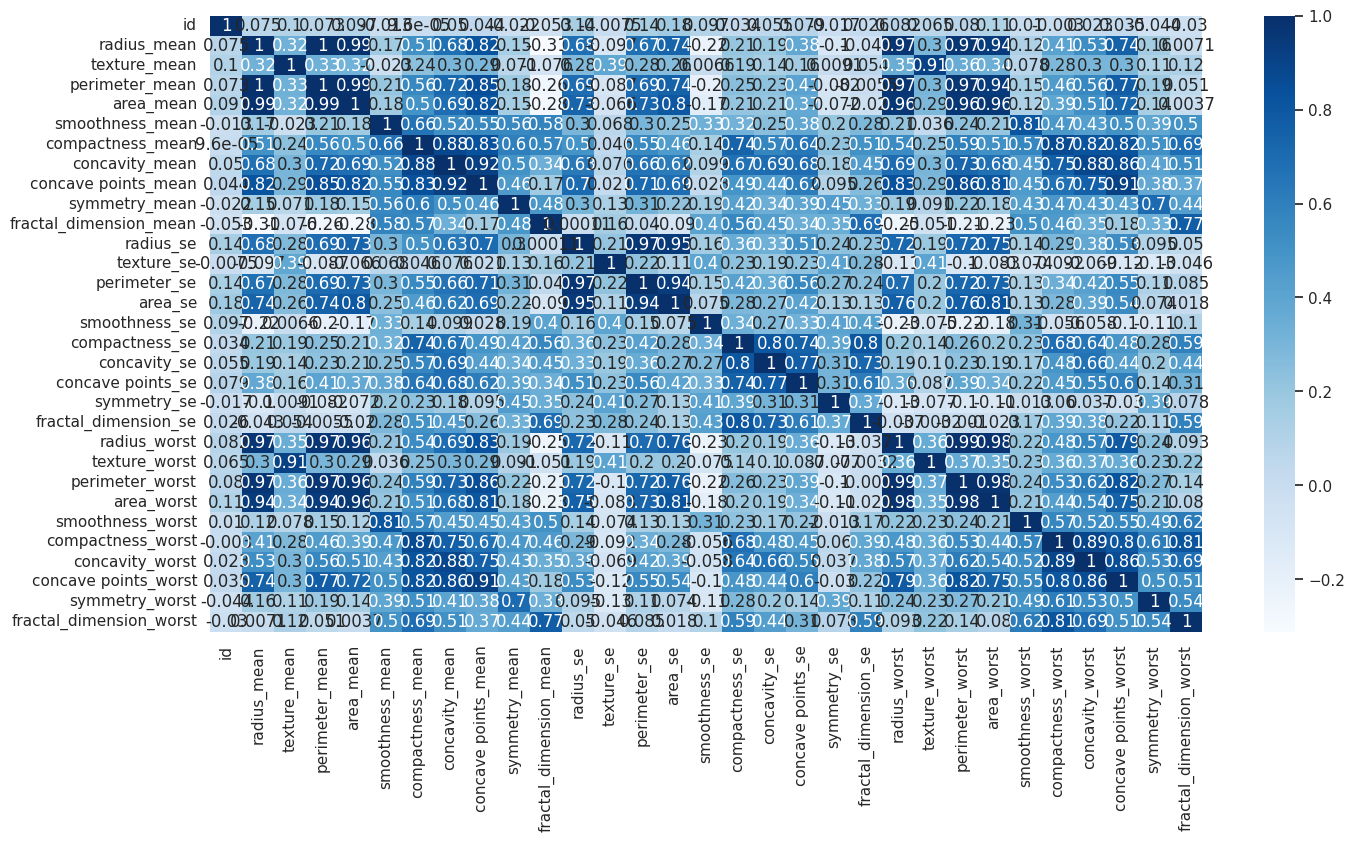

In [13]:
# Heatmap showing correlation between the attributes.
sns.heatmap(
    pandas_df.corr(), annot=True, cmap="Blues"
)

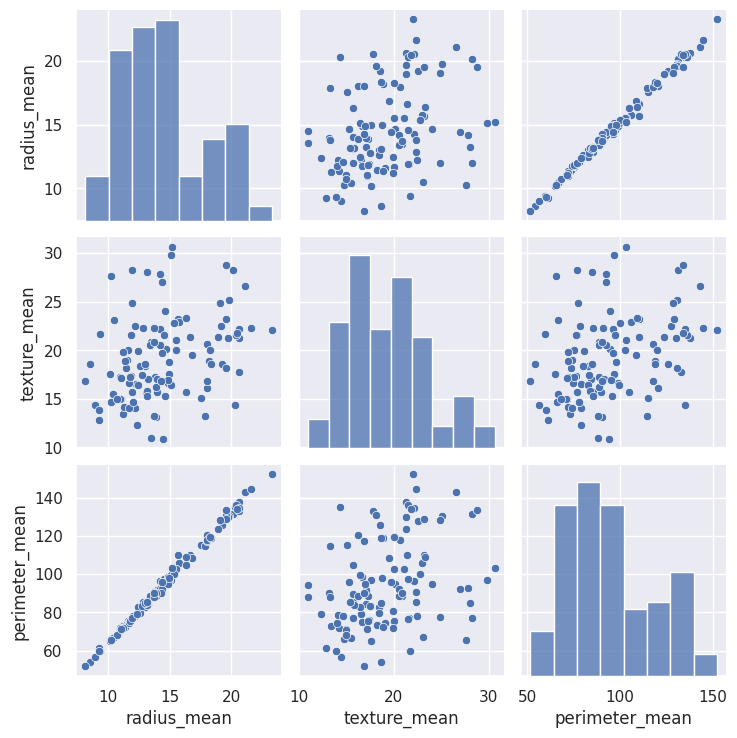

In [14]:
# Sample 20% of the data
sample_df = pandas_df.sample(frac=0.2)

# Select only a subset of the features
selected_features = ['radius_mean', 'texture_mean', 'perimeter_mean']

sns.pairplot(sample_df[selected_features])
plt.show()



As the dataset is large, it was taking me alot of time to compute

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'radius_mean'}>,
        <Axes: title={'center': 'texture_mean'}>,
        <Axes: title={'center': 'perimeter_mean'}>,
        <Axes: title={'center': 'area_mean'}>,
        <Axes: title={'center': 'smoothness_mean'}>],
       [<Axes: title={'center': 'compactness_mean'}>,
        <Axes: title={'center': 'concavity_mean'}>,
        <Axes: title={'center': 'concave points_mean'}>,
        <Axes: title={'center': 'symmetry_mean'}>,
        <Axes: title={'center': 'fractal_dimension_mean'}>,
        <Axes: title={'center': 'radius_se'}>],
       [<Axes: title={'center': 'texture_se'}>,
        <Axes: title={'center': 'perimeter_se'}>,
        <Axes: title={'center': 'area_se'}>,
        <Axes: title={'center': 'smoothness_se'}>,
        <Axes: title={'center': 'compactness_se'}>,
        <Axes: title={'center': 'concavity_se'}>],
       [<Axes: title={'center': 'concave points_se'}>,
        <Axes: title={'center': 's

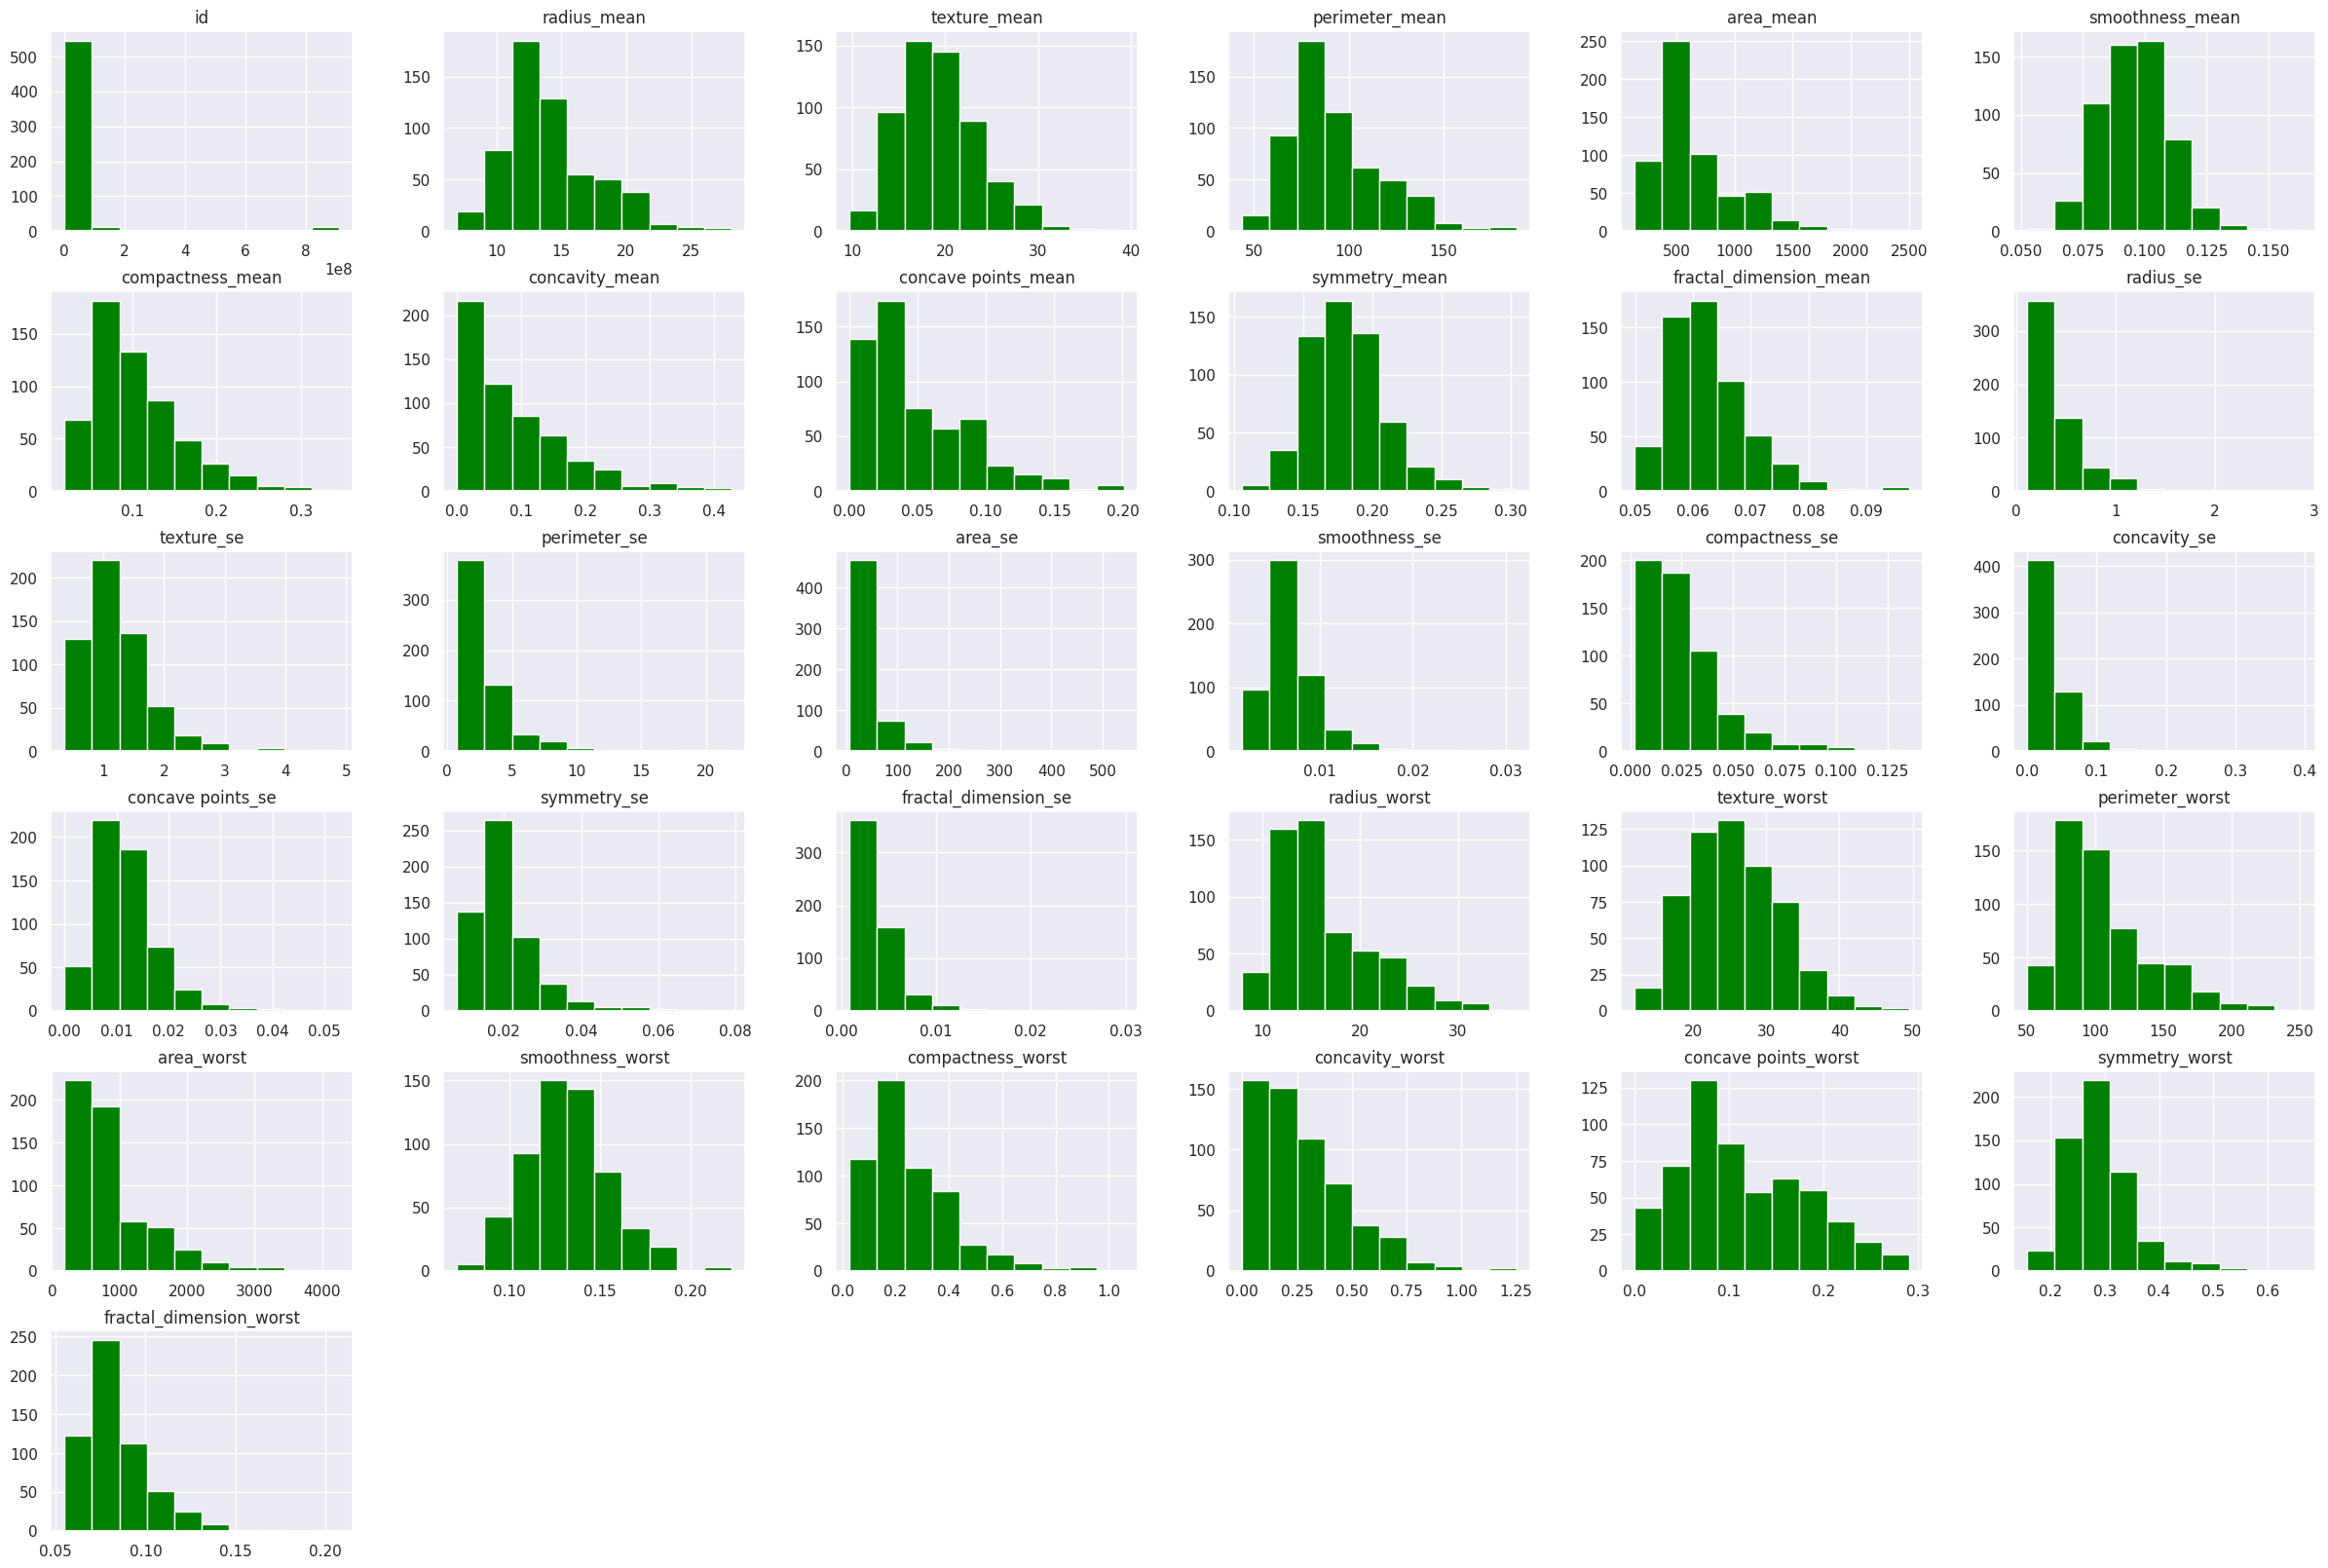

In [15]:
# Plotted Histogram
pandas_df.hist(color="green", figsize=(30, 20))

# **Identifing predictor significance**

In [16]:
import statsmodels.api as sm

# Convert diagnosis column to numerical (M=1, B=0)
pandas_df['diagnosis'] = pandas_df['diagnosis'].map({'M': 1, 'B': 0})

# Define independent variables (features) and dependent variable (response)
X = pandas_df[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean']]
y = pandas_df['diagnosis']

# Add a constant to the model
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

# Print out the statistics
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              diagnosis   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     205.9
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          1.40e-124
Time:                        07:40:49   Log-Likelihood:                -98.039
No. Observations:                 569   AIC:                             208.1
Df Residuals:                     563   BIC:                             234.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.4931      0.217    -

## Is the relationship significant?

1. radius_mean has a p-value of 0.843 which is greater than 0.05, so it is not a significant feature.

2. texture_mean has a p-value of 0.000 which is lesser than 0.05, so it is a significant feature.

3. perimeter_mean has a p-value of 0.005 which is lesser than 0.05, so it is a significant feature.

4. area_mean has a p-value of 0.000 which is lesser than 0.05, so it is a significant feature.

5. smoothness_mean has a p-value of 0.000 which is lesser than 0.05, so it is a significant feature.

The relationship is significant when the p-value for the predictor variables is less than 0.05. If it is higher than 0.05, the result is non-significant. From the OLS method, the variables "texture_mean", "perimeter_mean", "area_mean", and "smoothness_mean" have p-values less than 0.05, indicating that they are statistically significant in the model. Any change in these variables has a significant impact on the target variable (diagnosis).

However, the variable "radius_mean" is not significant, indicating that, within the context of this model, changes in this variable might not significantly affect the diagnosis.

Therefore, for the breast cancer dataset, we can conclude that the relationship is significant for most of the features selected in the model, but not all.







## **VIF(multicollinearity)**

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Indicate which variables to compute VIF for
# Note: From the dataset you've shared, I've chosen a subset of features for the VIF computation. Feel free to include or exclude features as you see fit.
features = pandas_df[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean']]

# Compute VIF
vif = pd.DataFrame()
vif["variables"] = features.columns
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif)


         variables          VIF
0      radius_mean  3526.872924
1     texture_mean    22.329552
2   perimeter_mean  4527.360366
3        area_mean    89.413301
4  smoothness_mean    49.764471


In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Drop the columns if they exist in the DataFrame
cols_to_drop = [col for col in ['id', 'diagnosis'] if col in pandas_df.columns]
features = pandas_df.drop(columns=cols_to_drop)

# Compute VIF
vif = pd.DataFrame()
vif["variables"] = features.columns
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif)



                  variables           VIF
0               radius_mean  63306.172036
1              texture_mean    251.047108
2            perimeter_mean  58123.586079
3                 area_mean   1287.262339
4           smoothness_mean    393.398166
5          compactness_mean    200.980354
6            concavity_mean    157.855046
7       concave points_mean    154.241268
8             symmetry_mean    184.426558
9    fractal_dimension_mean    629.679874
10                radius_se    236.665738
11               texture_se     24.675367
12             perimeter_se    211.396334
13                  area_se     72.466468
14            smoothness_se     26.170243
15           compactness_se     44.919651
16             concavity_se     33.244099
17        concave points_se     53.698656
18              symmetry_se     37.176452
19     fractal_dimension_se     27.532631
20             radius_worst   9674.742602
21            texture_worst    343.004387
22          perimeter_worst   4487

VIF stands for Variance Inflation Factor. It signifies multicollinearity among a set of different independent variables. A VIF value greater than 10 indicates that the independent variable is highly correlated with other variables in the set. We have calculated VIF values for all variables to check for multicollinearity.

From these values, the variables radius_mean, perimeter_mean, area_mean, radius_worst, and perimeter_worst have VIF values significantly greater than 10, suggesting they are highly correlated with other variables in the dataset.

In [19]:
# Converted Pandas Dataframe to H2O dataframe to proceed with AutoML
df = h2o.H2OFrame(
    pandas_df
)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [20]:
df.types

{'id': 'int',
 'diagnosis': 'int',
 'radius_mean': 'real',
 'texture_mean': 'real',
 'perimeter_mean': 'real',
 'area_mean': 'real',
 'smoothness_mean': 'real',
 'compactness_mean': 'real',
 'concavity_mean': 'real',
 'concave points_mean': 'real',
 'symmetry_mean': 'real',
 'fractal_dimension_mean': 'real',
 'radius_se': 'real',
 'texture_se': 'real',
 'perimeter_se': 'real',
 'area_se': 'real',
 'smoothness_se': 'real',
 'compactness_se': 'real',
 'concavity_se': 'real',
 'concave points_se': 'real',
 'symmetry_se': 'real',
 'fractal_dimension_se': 'real',
 'radius_worst': 'real',
 'texture_worst': 'real',
 'perimeter_worst': 'real',
 'area_worst': 'real',
 'smoothness_worst': 'real',
 'compactness_worst': 'real',
 'concavity_worst': 'real',
 'concave points_worst': 'real',
 'symmetry_worst': 'real',
 'fractal_dimension_worst': 'real'}

In [21]:
# Setting up the data split between training and test dataset.
pct_rows = 0.80
df_train, df_test = df.split_frame([pct_rows])

In [22]:
#printing shapes
print(df_train.shape)
print(df_test.shape)

(455, 32)
(114, 32)


In [23]:
#displaying the first few rows of a dataframe
df_train.head()

id    diagnosis    radius_mean    texture_mean    perimeter_mean    area_mean    smoothness_mean    compactness_mean    concavity_mean    concave points_mean    symmetry_mean    fractal_dimension_mean    radius_se    texture_se    perimeter_se    area_se    smoothness_se    compactness_se    concavity_se    concave points_se    symmetry_se    fractal_dimension_se    radius_worst    texture_worst    perimeter_worst    area_worst    smoothness_worst    compactness_worst    concavity_worst    concave points_worst    symmetry_worst    fractal_dimension_worst
----------------  -----------  -------------  --------------  ----------------  -----------  -----------------  ------------------  ----------------  ---------------------  ---------------  ------------------------  -----------  ------------  --------------  ---------  ---------------  ----------------  --------------  -------------------  -------------  ----------------------  --------------  ---------------  -----------------  ------------  ------------------  -------------------  -----------------  ----------------------  ----------------  -------------------------
842302                      1          17.99           10.38            122.8        1001              0.1184              0.2776            0.3001                 0.1471            0.2419                   0.07871       1.095         0.9053           8.589     153.4          0.006399          0.04904          0.05373             0.01587         0.03003                0.006193           25.38            17.33             184.6         2019                0.1622               0.6656             0.7119                 0.2654             0.4601                    0.1189
842517                      1          20.57           17.77            132.9        1326              0.08474             0.07864           0.0869                 0.07017           0.1812                   0.05667       0.5435        0.7339           3.398      74.08         0.005225          0.01308          0.0186              0.0134          0.01389                0.003532           24.99            23.41             158.8         1956                0.1238               0.1866             0.2416                 0.186              0.275                     0.08902
     8.43009e+07            1          19.69           21.25            130          1203              0.1096              0.1599            0.1974                 0.1279            0.2069                   0.05999       0.7456        0.7869           4.585      94.03         0.00615           0.04006          0.03832             0.02058         0.0225                 0.004571           23.57            25.53             152.5         1709                0.1444               0.4245             0.4504                 0.243              0.3613                    0.08758
     8.43584e+07            1          20.29           14.34            135.1        1297              0.1003              0.1328            0.198                  0.1043            0.1809                   0.05883       0.7572        0.7813           5.438      94.44         0.01149           0.02461          0.05688             0.01885         0.01756                0.005115           22.54            16.67             152.2         1575                0.1374               0.205              0.4                    0.1625             0.2364                    0.07678
843786                      1          12.45           15.7              82.57        477.1            0.1278              0.17              0.1578                 0.08089           0.2087                   0.07613       0.3345        0.8902           2.217      27.19         0.00751           0.03345          0.03672             0.01137         0.02165                0.005082           15.47            23.75             103.4          741.6              0.1791               0.5249             0.5355                 0.1741             0.3985                  

In [24]:
df_test.head()

id    diagnosis    radius_mean    texture_mean    perimeter_mean    area_mean    smoothness_mean    compactness_mean    concavity_mean    concave points_mean    symmetry_mean    fractal_dimension_mean    radius_se    texture_se    perimeter_se    area_se    smoothness_se    compactness_se    concavity_se    concave points_se    symmetry_se    fractal_dimension_se    radius_worst    texture_worst    perimeter_worst    area_worst    smoothness_worst    compactness_worst    concavity_worst    concave points_worst    symmetry_worst    fractal_dimension_worst
----------------  -----------  -------------  --------------  ----------------  -----------  -----------------  ------------------  ----------------  ---------------------  ---------------  ------------------------  -----------  ------------  --------------  ---------  ---------------  ----------------  --------------  -------------------  -------------  ----------------------  --------------  ---------------  -----------------  ------------  ------------------  -------------------  -----------------  ----------------------  ----------------  -------------------------
     8.43483e+07            1         11.42            20.38             77.58        386.1            0.1425              0.2839            0.2414                 0.1052            0.2597                   0.09744       0.4956        1.156            3.445      27.23         0.00911            0.07458         0.05661             0.01867         0.05963                0.009208           14.91            26.5               98.87         567.7              0.2098               0.8663            0.6869                  0.2575             0.6638                    0.173
846226                      1         19.17            24.8             132.4        1123              0.0974              0.2458            0.2065                 0.1118            0.2397                   0.078         0.9555        3.568           11.07      116.2          0.003139           0.08297         0.0889              0.0409          0.04484                0.01284            20.96            29.94             151.7         1332                0.1037               0.3903            0.3639                  0.1767             0.3176                    0.1023
846381                      1         15.85            23.95            103.7         782.7            0.08401             0.1002            0.09938                0.05364           0.1847                   0.05338       0.4033        1.078            2.903      36.58         0.009769           0.03126         0.05051             0.01992         0.02981                0.003002           16.84            27.66             112            876.5              0.1131               0.1924            0.2322                  0.1119             0.2809                    0.06287
     8.4799e+07             1         14.54            27.54             96.73        658.8            0.1139              0.1595            0.1639                 0.07364           0.2303                   0.07077       0.37          1.033            2.879      32.55         0.005607           0.0424          0.04741             0.0109          0.01857                0.005466           17.46            37.13             124.1          943.2              0.1678               0.6577            0.7026                  0.1712             0.4218                    0.1341
     8.51065e+06            0         13.08            15.71             85.63        520              0.1075              0.127             0.04568                0.0311            0.1967                   0.06811       0.1852        0.7477           1.383      14.67         0.004097           0.01898         0.01698             0.00649         0.01678                0.002425           14.5             20.49              96.09         630.5              0.1312               0.2776            0.189                   0.07283            0.3184                    0

In [25]:
X = df.columns
print(X)

['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [26]:
# Set target and predictor variables
y = "diagnosis"
X.remove(y)  # Removing the result frm our predictors data
print(X)

['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


## Train AutoML Models

In [27]:
# Setting of AutoML
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)

Start the training by specifying:
training_frame: the dataframe that contains training data -- df_train in our case
y: the column in the training_frame which contains the target variable -- diagnosis in our case

In [32]:
# Trainig the dataset on different models
aml.train(x=X, y=y, training_frame=df_train)

AutoML progress: |
07:42:39.257: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

███
07:42:47.561: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█
07:42:50.535: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█
07:42:55.146: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
07:42:55.426: _response param, We have det

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_4_AutoML_1_20231011_74238


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       3/6
# GBM base models (used / total)           1/1
# XGBoost base models (used / total)       1/1
# DeepLearning base models (used / total)  1/1
# DRF base models (used / total)           0/2
# GLM base models (used / total)           0/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.007819929074238185
RMSE: 0.0884303628525756
MAE: 0.05672342747698491
RMSLE: 0.06801116334053803
Mean Residual Deviance: 0.007819929074238185
R^2: 0.9660774281997704
Null degrees of freedom: 454
Residual degrees of freedom: 451
Null deviance: 104.88791208791208
Residual deviance: 3.558067728778374
AIC: -906.0072411704833

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.026267397904557923
RMSE: 0.16207219966594494
MAE: 0.09486484460136406
RMSLE: 0.11750917170273172
Mean Residual Deviance: 0.026267397904557923
R^2: 0.886052970178713
Null degrees of freedom: 454
Residual degrees of freedom: 451
Null deviance: 105.30246287462296
Residual deviance: 11.951666046573855
AIC: -354.70509792014184

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     0.0949508  0.00744224  0.105481      0.0945354     0.0933516     0.0966798     0.0847063
mean_residual_deviance  0.0260506  0.0040383   0.0253533     0.0309899     0.0226039     0.021901      0.0294047
mse                     0.0260506  0.0040383   0.0253533     0.0309899     0.0226039     0.021901      0.0294047
null_deviance           21.0605    2.15905     22.7043       23.9335       19.3324       19.028        20.3042
r2                      0.885908   0.0184654   0.895424      0.869736      0.895807      0.905601      0.862973
residual_deviance       2.39023    0.533481    2.3325        3.09899       1.98915       1.79588       2.73464
rmse                    0.161016   0.0124688   0.159227      0.17604       0.150346      0.14799       0.171478
rmsle                   0.116977   0.00715824  0.114573      0.12286       0.118355      0.105864      0.123235

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [33]:
# Leaderboard showing the performance of different models on the dataset.

lb=aml.leaderboard
lb.head(rows=lb.nrows)

model_id                                                    rmse        mse        mae     rmsle    mean_residual_deviance
------------------------------------------------------  --------  ---------  ---------  --------  ------------------------
StackedEnsemble_BestOfFamily_4_AutoML_1_20231011_74238  0.162072  0.0262674  0.0948648  0.117509                 0.0262674
GBM_grid_1_AutoML_1_20231011_74238_model_22             0.170047  0.0289161  0.0869813  0.120865                 0.0289161
GBM_grid_1_AutoML_1_20231011_74238_model_15             0.171583  0.0294408  0.0815245  0.12294                  0.0294408
GBM_grid_1_AutoML_1_20231011_74238_model_26             0.172106  0.0296203  0.0818313  0.122563                 0.0296203
GBM_grid_1_AutoML_1_20231011_74238_model_1              0.172517  0.0297621  0.0877902  0.124881                 0.0297621
StackedEnsemble_BestOfFamily_3_AutoML_1_20231011_74238  0.172884  0.0298889  0.0887349  0.123917                 0.0298889
StackedEnsemble_AllModels_4_AutoML_1_20231011_74238     0.173411  0.0300715  0.110012   0.12442                  0.0300715
GBM_grid_1_AutoML_1_20231011_74238_model_28             0.173966  0.030264   0.0873112  0.123493                 0.030264
StackedEnsemble_AllModels_1_AutoML_1_20231011_74238     0.17524   0.0307091  0.0911867  0.125153                 0.0307091
GBM_grid_1_AutoML_1_20231011_74238_model_24             0.175765  0.0308933  0.0858885  0.124897                 0.0308933
GBM_grid_1_AutoML_1_20231011_74238_model_10             0.175768  0.0308946  0.0845839  0.124853                 0.0308946
StackedEnsemble_BestOfFamily_2_AutoML_1_20231011_74238  0.175953  0.0309596  0.0905742  0.125738                 0.0309596
StackedEnsemble_AllModels_2_AutoML_1_20231011_74238     0.176156  0.031031   0.0908719  0.126404                 0.031031
GBM_grid_1_AutoML_1_20231011_74238_model_23             0.176481  0.0311455  0.0817294  0.125554                 0.0311455
GBM_2_AutoML_1_20231011_74238                           0.177004  0.0313305  0.0779535  0.125832                 0.0313305
GBM_grid_1_AutoML_1_20231011_74238_model_9              0.177248  0.0314167  0.0817927  0.125995                 0.0314167
XGBoost_grid_1_AutoML_1_20231011_74238_model_2          0.177784  0.031607   0.0854378  0.126009                 0.031607
GBM_grid_1_AutoML_1_20231011_74238_model_3              0.178211  0.0317592  0.0890987  0.127984                 0.0317592
GBM_grid_1_AutoML_1_20231011_74238_model_8              0.17827   0.0317803  0.0730019  0.128209                 0.0317803
GBM_grid_1_AutoML_1_20231011_74238_model_5              0.179241  0.0321274  0.0815848  0.128378                 0.0321274
StackedEnsemble_AllModels_3_AutoML_1_20231011_74238     0.179824  0.0323365  0.113576   0.128233                 0.0323365
GBM_grid_1_AutoML_1_20231011_74238_model_13             0.179872  0.0323538  0.0776819  0.128883                 0.0323538
XGBoost_grid_1_AutoML_1_20231011_74238_model_1          0.180115  0.0324414  0.0967704  0.12988                  0.0324414
XGBoost_grid_1_AutoML_1_20231011_74238_model_7          0.180227  0.0324818  0.093204   0.130631                 0.0324818
GBM_grid_1_AutoML_1_20231011_74238_model_11             0.180319  0.0325149  0.100965   0.128991                 0.0325149
GBM_grid_1_AutoML_1_20231011_74238_model_7              0.180415  0.0325497  0.0827427  0.127063                 0.0325497
GBM_grid_1_AutoML_1_20231011_74238_model_12             0.180502  0.0325809  0.0732646  0.128753                 0.0325809
GBM_3_AutoML_1_20231011_74238                           0.180565  0.0326038  0.080975   0.129144                 0.0326038
DeepLearning_grid_1_AutoML_1_20231011_74238_model_1     0.181332  0.0328812  0.127866   0.137841                 0.0328812
StackedEnsemble_BestOfFamily_1_AutoML_1_20231011_74238  0.181847  0.0330683  0.10929    0.131677                 0.0330683
GBM_4_AutoML_1_20231011_74238                           0.182135  0

## How did AutoML pick this model?


In [34]:
#assign index values to all the models generated
model_index = 0
glm_index = 0
glm_model = ""
aml_leaderboard_df = aml.leaderboard.as_data_frame()
models_dict = {}
for m in aml_leaderboard_df["model_id"]:
    models_dict[m] = model_index
    if "StackedEnsemble" not in m:
        break
    model_index = model_index + 1

for m in aml_leaderboard_df["model_id"]:
    if "GLM" in m:
        models_dict[m] = glm_index
        break
    glm_index = glm_index + 1
models_dict

{'StackedEnsemble_BestOfFamily_4_AutoML_1_20231011_74238': 0,
 'GBM_grid_1_AutoML_1_20231011_74238_model_22': 1,
 'GLM_1_AutoML_1_20231011_74238': 74}

In [35]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index, "model_id"])

1


In [36]:
best_model.algo

'gbm'

In [37]:
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
import matplotlib.cbook

warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

<ipython-input-37-a0f01d27643e>:8: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)


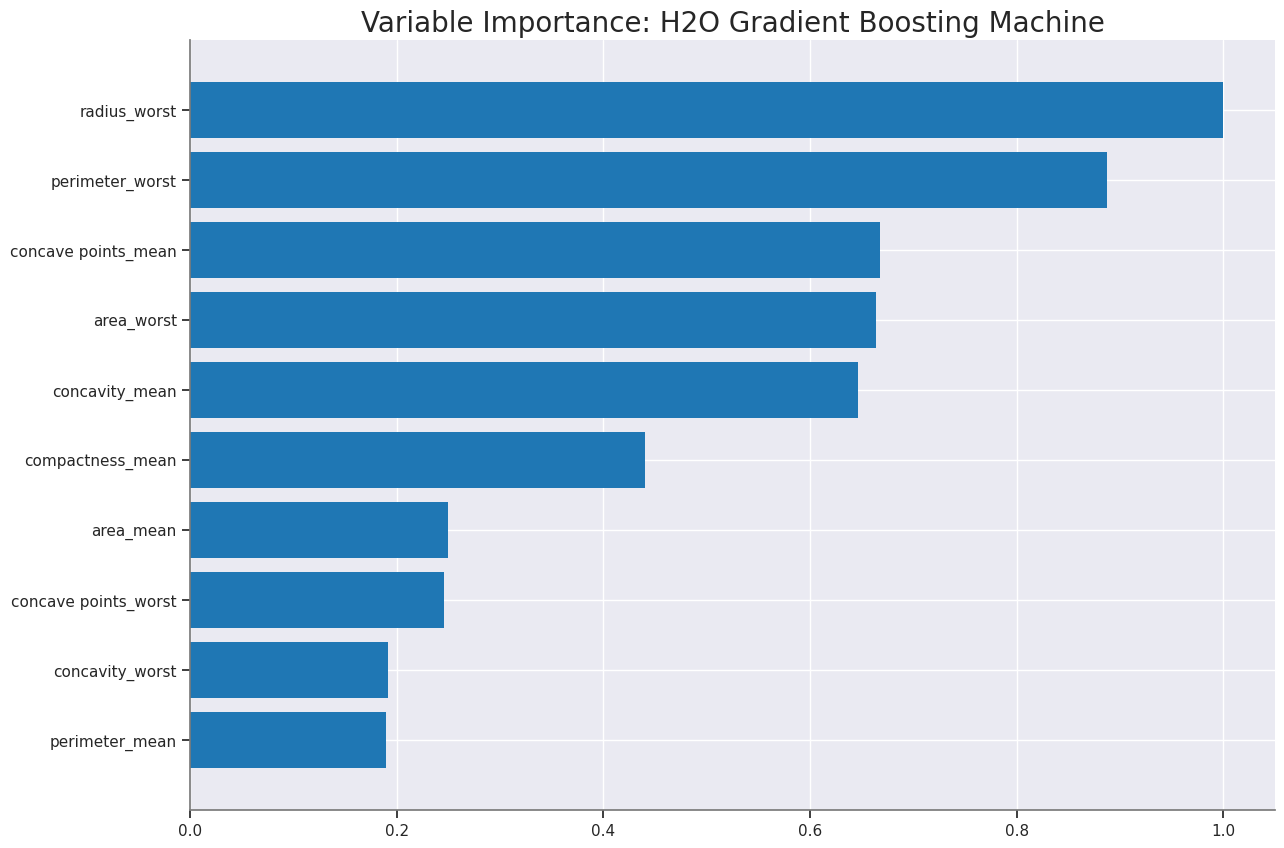

<Figure size 1600x800 with 0 Axes>

In [38]:
# Importance of all the variables in GBM algorithm.
if best_model.algo in [
    "gbm",
    "drf",
    "xrt",
    "xgboost"
    "StackedEnsemble",
]:
    best_model.varimp_plot()

Observations:
The above graph is a variable Importance Graph on the H20's Distributed Gradient boosting Machine Model

`

<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-39-878b7dc4a148>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if glm_index is not 0:


74
glm


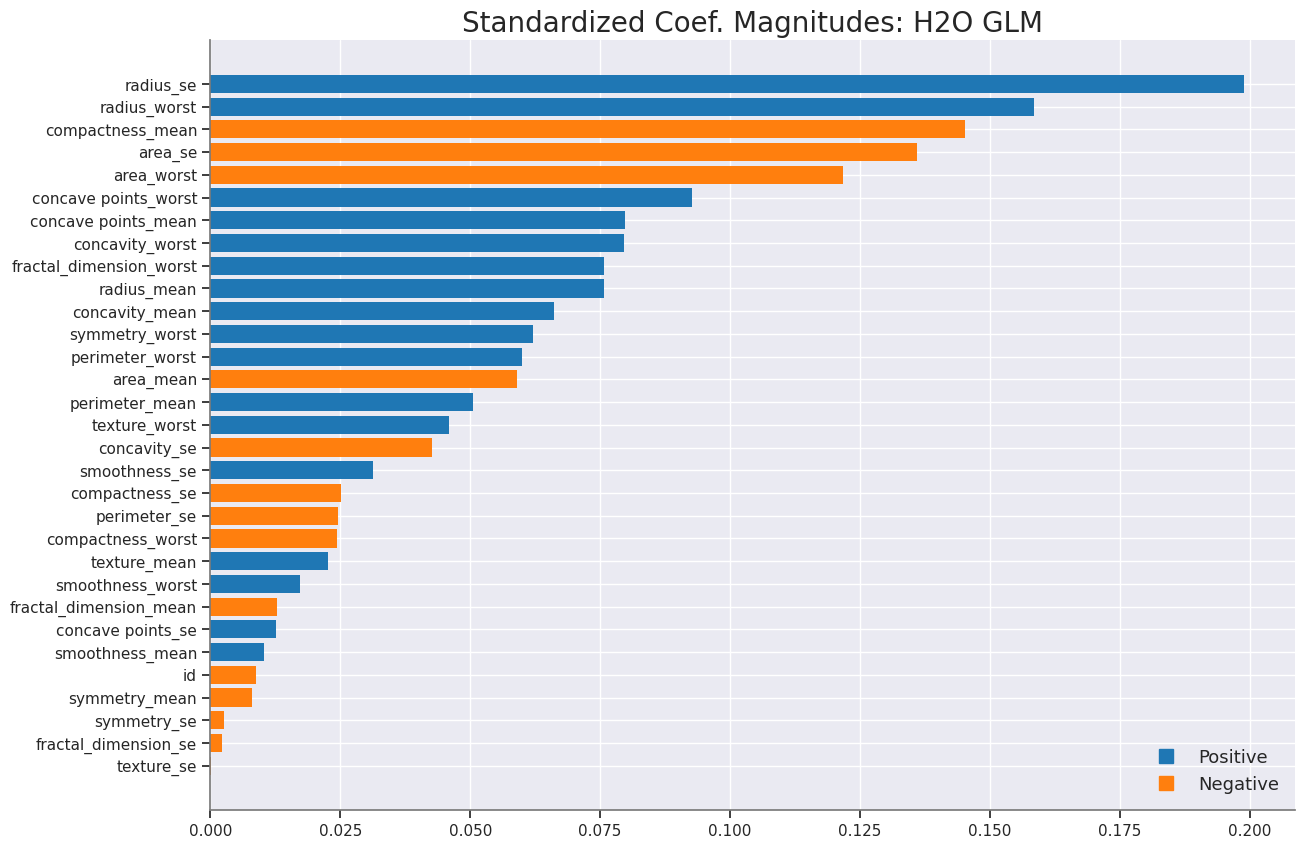

In [39]:
#standardized coef Magnitudes for h20 GML
if glm_index is not 0:
    print(glm_index)
    glm_model = h2o.get_model(aml.leaderboard[glm_index, "model_id"])
    print(glm_model.algo)
    glm_model.std_coef_plot()

Analysis:
Standardized coefficient magnitudes (sometimes referred to as standardized coefficients or beta coefficients) are a measure of the importance of each input variable in a predictive model, after standardizing all variables to have a mean of zero and a standard deviation of one. The values of standardized coefficient magnitudes can range from negative infinity to positive infinity, but they are typically expressed as a percentage.

The values on standardized coefficient magnitudes represent the relative importance of each input variable in the model, after taking into account the scale of the variable. A higher magnitude value indicates that the variable has a stronger impact on the outcome variable, while a lower value indicates a weaker impact.

In [40]:
print(best_model.rmse(train=True))

0.07965853145734456


## Now, let's see how the best model performs on our test set.

In [41]:
aml.leader.model_performance(test_data=df_test)


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.034333898632137705
RMSE: 0.18529408687850163
MAE: 0.11566558251152473
RMSLE: 0.1406276014483627
Mean Residual Deviance: 0.034333898632137705
R^2: 0.859152984020435
Null degrees of freedom: 113
Residual degrees of freedom: 110
Null deviance: 28.208303345006588
Residual deviance: 3.9140644440636985
AIC: -50.84693548717257

In [42]:
predictions = best_model.predict(df_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [43]:
# Predictions on Test Dataset using the best model from the leaderboard.
y_pred = h2o.as_list(
    predictions
)
print(y_pred)


      predict
0    0.759714
1    0.976931
2    0.688343
3    1.060611
4   -0.022839
..        ...
109 -0.004823
110  0.001723
111 -0.007503
112  0.861439
113  1.032815

[114 rows x 1 columns]


Regularization
In this Section, we will be using the GLM model to check if regularization is helping us to improve the accuracy and reduce overfitting.

Ridge and Lasso are regularization techniques used in linear regression to prevent overfitting and improve the model's generalization ability.

Ridge regularization adds a penalty term to the least-squares objective function of the linear regression model. This penalty term is proportional to the square of the magnitude of the coefficients of the model, which shrinks the coefficients towards zero. The strength of the penalty is controlled by a hyperparameter called the regularization parameter, which needs to be tuned to achieve the best performance. Ridge regularization is particularly useful when there are many input variables that are correlated with each other, as it can help to reduce the variance of the model by reducing the effect of these correlated variables.

Lasso regularization is similar to Ridge regularization, but instead of adding a penalty term proportional to the square of the coefficients, it adds a penalty term proportional to the absolute value of the coefficients. This penalty term can set some coefficients to exactly zero, which makes Lasso regularization a useful method for feature selection. By setting some coefficients to zero, Lasso can effectively remove irrelevant variables from the model, which can lead to a simpler and more interpretable model.

The main difference between Ridge and Lasso regularization is the type of penalty function used. Ridge uses L2 regularization, while Lasso uses L1 regularization. L2 regularization tends to distribute the penalty evenly across all coefficients, while L1 regularization tends to concentrate the penalty on a smaller subset of the most important coefficients. Which method to use depends on the specific problem and the properties of the input variables.

By adding regularization to a model, it can become less prone to overfitting and better at generalizing to new data.

In [44]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
 # Elastic Net Regularization
disease_glm = H2OGeneralizedLinearEstimator(
    family="gaussian", lambda_=0, compute_p_values=True, nfolds=5
)
# RIDGE Regularization
disease_glm_regularization_ridge = H2OGeneralizedLinearEstimator(
    family="gaussian", alpha=0, nfolds=5
)
# LASSO Regularization
disease_glm_regularization_lasso = H2OGeneralizedLinearEstimator(
    family="gaussian", alpha=1, nfolds=5
)
# Lambda Search
disease_glm_regularization_lamba_search = H2OGeneralizedLinearEstimator(
    lambda_search=True
)

In [45]:
disease_glm.train(x=X, y=y, training_frame=df_train)

glm Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1697010007580_26


GLM Model: summary
    family    link      regularization    number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ----------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  None              31                            31                             1                       py_2_sid_9bcc

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.050653966448147535
RMSE: 0.22506436067966767
MAE: 0.17773171992298484
RMSLE: 0.16576033587036212
Mean Residual Deviance: 0.050653966448147535
R^2: 0.780264910654435
Null degrees of freedom: 454
Residual degrees of freedom: 423
Null deviance: 104.88791208791208
Residual deviance: 23.047554733907127
AIC: 0.08839331941605622

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.06558534617029697
RMSE: 0.2560963611031929
MAE: 0.1991645790787993
RMSLE: 0.1949560094056025
Mean Residual Deviance: 0.06558534617029697
R^2: 0.7154931210521807
Null degrees of freedom: 454
Residual degrees of freedom: 423
Null deviance: 105.10219438627668
Residual deviance: 29.84133250748512
AIC: 117.6307049774544

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     0.198442   0.0130074   0.199892      0.20578       0.203778      0.175686      0.207074
mean_residual_deviance  0.0652665  0.00981893  0.0625329     0.0816276     0.0599479     0.0562294     0.0659946
mse                     0.0652665  0.00981893  0.0625329     0.0816276     0.0599479     0.0562294     0.0659946
null_deviance           21.0204    2.71114     24.661        22.3713       18.483        18.2326       21.3543
r2                      0.716154   0.0382848   0.731106      0.660493      0.733406      0.759254      0.696508
residual_deviance       5.96827    1.28564     6.62848       7.50974       4.91573       4.3859        6.40148
rmse                    0.254927   0.0186637   0.250066      0.285706      0.244843      0.237127      0.256894
rmsle                   0.193318   0.0213447   0.180403      0.218861      0.186078      0.168989      0.21226

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective           training_rmse        training_deviance     training_mae         training_r2
--  -------------------  ----------  ------------  -------------------------  ------------------  -------------------  --------------------  -------------------  -----------------
    2023-10-11 07:47:32  0.000 sec   0             104.88791208791208         0.2305228837096969
    2023-10-11 07:47:32  0.011 sec   1                                                            0.22506436067966767  0.050653966448147535  0.17773171992298484  0.780264910654435

Variable Importances: 
variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ----------------------
radius_worst       0.8139948844909668     1.0                    0.1851375630452689
radius_mean        0.6727789044380188     0.8265149047696317     0.15301895528964213
area_worst         0.669232964515686      0.8221586858425923     0.15221245553339838
perimeter_mean     0.351985365152359      0.4324171709905446     0.08005666125611878
radius_se          0.24884860217571259    0.3057127347075781     0.056598910695665805
area_mean          0.24883010983467102    0.3056900167011214     0.05659470473931317
compactness_mean   0.2442946881055832     0.3001182105196562     0.055563154121116134
perimeter_se       0.16085900366

## Ridge Regularization

In [46]:
#training a generalized linear model (GLM) with Ridge regularization
disease_glm_regularization_ridge.train(x=X, y=y, training_frame=df_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1697010007580_27


GLM Model: summary
    family    link      regularization              number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  --------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Ridge ( lambda = 0.03817 )  31                            31                             1                       py_2_sid_9bcc

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.05435239105569456
RMSE: 0.23313599262167684
MAE: 0.18504605997895282
RMSLE: 0.16909684516117823
Mean Residual Deviance: 0.05435239105569456
R^2: 0.7642212773802455
Null degrees of freedom: 454
Residual degrees of freedom: 423
Null deviance: 104.88791208791208
Residual deviance: 24.730337930341026
AIC: 32.15272912975409

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.05983885888351444
RMSE: 0.24461982520538772
MAE: 0.1946891394989473
RMSLE: 0.17953812067340383
Mean Residual Deviance: 0.05983885888351444
R^2: 0.7404211767588724
Null degrees of freedom: 454
Residual degrees of freedom: 423
Null deviance: 105.47997737478049
Residual deviance: 27.22668079199907
AIC: 75.90855841048696

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     0.194522  0.00676184  0.196095      0.187149      0.194155      0.190296      0.204917
mean_residual_deviance  0.059674  0.00538654  0.0578621     0.0571009     0.0626856     0.0534273     0.067294
mse                     0.059674  0.00538654  0.0578621     0.0571009     0.0626856     0.0534273     0.067294
null_deviance           21.096    3.21383     26.159        19.8243       21.8373       17.5566       20.1028
r2                      0.737516  0.0282744   0.765773      0.745868      0.720734      0.758026      0.697177
residual_deviance       5.44534   0.808128    5.84407       5.02488       6.08051       4.22076       6.05646
rmse                    0.244086  0.0109624   0.240545      0.238958      0.250371      0.231143      0.259411
rmsle                   0.179063  0.0119019   0.173066      0.180981      0.178607      0.16526       0.1974

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective           training_rmse        training_deviance    training_mae         training_r2
--  -------------------  ----------  ------------  -------------------------  ------------------  -------------------  -------------------  -------------------  ------------------
    2023-10-11 07:47:36  0.000 sec   0             104.88791208791208         0.2305228837096969
    2023-10-11 07:47:36  0.004 sec   1                                                            0.23313599262167684  0.05435239105569456  0.18504605997895282  0.7642212773802455

Variable Importances: 
variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
radius_se                0.12885935604572296    1.0                   0.09448188607725355
area_se                  0.1015201061964035     0.7878365165846497    0.07443628000745116
radius_worst             0.10048501193523407    0.7798037722583305    0.07367733117312415
compactness_mean         0.0966293066740036     0.7498819615373273    0.0708502620613572
concave points_worst     0.08415111899375916    0.6530462480652157    0.061701041212875576
concave points_mean      0.07339266687631607    0.5695563684974048    0.05381275992294604
concavity_worst          0.07277155667543411    0.56473630560137

## Lasso Regularization

In [47]:
#training a generalized linear model (GLM) with Lasso regularization
disease_glm_regularization_lasso.train(x=X, y=y, training_frame=df_train)


glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1697010007580_28


GLM Model: summary
    family    link      regularization             number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Lasso (lambda = 0.03817 )  31                            6                              1                       py_2_sid_9bcc

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.06659323822928608
RMSE: 0.25805665701408687
MAE: 0.2081069763061546
RMSLE: 0.18212306732260267
Mean Residual Deviance: 0.06659323822928608
R^2: 0.7111209214563333
Null degrees of freedom: 454
Residual degrees of freedom: 448
Null deviance: 104.88791208791208
Residual deviance: 30.299923394325166
AIC: 74.56979843734516

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.07062751314394523
RMSE: 0.2657583736102124
MAE: 0.21565497302003694
RMSLE: 0.18703495202142664
Mean Residual Deviance: 0.07062751314394523
R^2: 0.6936203815978279
Null degrees of freedom: 454
Residual degrees of freedom: 448
Null deviance: 105.1624661598525
Residual deviance: 32.13551848049508
AIC: 101.33141007288782

Cross-Validation Metrics Summary: 
                        mean       sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ---------  ------------  ------------  ------------  ------------  ------------
mae                     0.213212   0.0219722  0.206978      0.244736      0.22309       0.20518       0.186075
mean_residual_deviance  0.0696178  0.0110677  0.0649826     0.0877994     0.0721605     0.0625784     0.060568
mse                     0.0696178  0.0110677  0.0649826     0.0877994     0.0721605     0.0625784     0.060568
null_deviance           21.0325    3.86108    23.1801       24.661        22.5962       19.8598       14.8654
r2                      0.696929   0.0432895  0.710336      0.622459      0.703297      0.713463      0.735093
residual_deviance       6.4271     1.95036    6.69321       9.30674       6.5666        5.63205       3.93692
rmse                    0.263223   0.020351   0.254917      0.29631       0.268627      0.250157      0.246106
rmsle                   0.185546   0.0137021  0.175895      0.208617      0.1874        0.179559      0.176257

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective           training_rmse        training_deviance    training_mae        training_r2
--  -------------------  ----------  ------------  -------------------------  ------------------  -------------------  -------------------  ------------------  ------------------
    2023-10-11 07:47:40  0.000 sec   0             104.88791208791208         0.2305228837096969
    2023-10-11 07:47:40  0.006 sec   1                                                            0.25805665701408687  0.06659323822928608  0.2081069763061546  0.7111209214563333

Variable Importances: 
variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
radius_worst             0.15006621181964874    1.0                  0.3467720891123295
concave points_worst     0.1395738273859024     0.9300816332569506   0.3225263510095202
texture_worst            0.05312112718820572    0.35398459482703065  0.12275197746175093
concave points_mean      0.05083668977022171    0.33876173159696876  0.1174731133771911
symmetry_worst           0.027667101472616196   0.18436596177870357  0.06393296972720493
smoothness_worst         0.01148674450814724    0.07654450904612783  0.026543499312003352
id                       0.0                    0.0                  0.0
radius_

Did Regularization Method Help?
The Lasso regularization appears to have the same MSE, RMSE, MAE, and RMSLE values compared to the non-regularized and Ridge regularized models, indicating no improvement in performance. The R-squared value also decreased from **0.683 to 0.653** in cross validation data, indicating a worse fit to the data.

Here, we can observe that after applying the ridge regularization, there are barely or no improvements in the evaluation metrics on the train data and cross validation data, hence it can be concluded that regularization technique is not so helpful to avoid the overfitting of model

In [48]:
lambda_search = disease_glm_regularization_lamba_search.train(
    x=X, y=y, training_frame=df_train
)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [49]:
lambda_search

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1697010007580_29


GLM Model: summary
    family    link      regularization                                 lambda_search                                                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------------------------  ----------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 0.007634 )  nlambda = 100, lambda.max = 0.7634, lambda.min = 0.007634, lambda.1se = -1.0  31                            18                             100                     py_2_sid_9bcc

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.055313680607249324
RMSE: 0.23518860645713544
MAE: 0.18680563886441617
RMSLE: 0.16793535743249535
Mean Residual Deviance: 0.055313680607249324
R^2: 0.7600512377898795
Null degrees of freedom: 454
Residual degrees of freedom: 436
Null deviance: 104.88791208791208
Residual deviance: 25.16772467629844
AIC: 14.129634697137107

Scoring History: 
     timestamp            duration    iteration    lambda    predictors    deviance_train        alpha    iterations    training_rmse        training_deviance     training_mae         training_r2
---  -------------------  ----------  -----------  --------  ------------  --------------------  -------  ------------  -------------------  --------------------  -------------------  ------------------
     2023-10-11 07:47:44  0.000 sec   1            .76E0     1             0.23052288370969692   0.5
     2023-10-11 07:47:44  0.008 sec   2            .73E0     2             0.22096195960195972   0.5
     2023-10-11 07:47:44  0.010 sec   3            .7E0      3             0.21098288207132176   0.5
     2023-10-11 07:47:44  0.011 sec   4            .66E0     5             0.2001559496842938    0.5
     2023-10-11 07:47:44  0.012 sec   5            .63E0     5             0.18984041477634342   0.5
     2023-10-11 07:47:44  0.014 sec   6            .6E0      5             0.18033967936890727   0.5
     2023-10-11 07:47:44  0.014 sec   7            .58E0     5             0.17158432559798475   0.5
     2023-10-11 07:47:44  0.015 sec   8            .55E0     5             0.16351935197117093   0.5
     2023-10-11 07:47:44  0.016 sec   9            .53E0     5             0.15609434116729098   0.5
     2023-10-11 07:47:44  0.017 sec   10           .5E0      5             0.1492595776096015    0.5
---  ---                  ---         ---          ---       ---           ---                   ---      ---           ---                  ---                   ---                  ---
     2023-10-11 07:47:44  0.102 sec   91           .12E-1    18            0.057505610051255616  0.5
     2023-10-11 07:47:44  0.109 sec   92           .11E-1    18            0.05717998795039002   0.5
     2023-10-11 07:47:44  0.113 sec   93           .11E-1    18            0.056878828492161713  0.5
     2023-10-11 07:47:44  0.114 sec   94           .1E-1     18            0.056601631542364896  0.5
     2023-10-11 07:47:44  0.115 sec   95           .96E-2    18            0.056343459110097596  0.5
     2023-10-11 07:47:44  0.121 sec   96           .92E-2    18            0.05610465147705374   0.5
     2023-10-11 07:47:44  0.122 sec   97           .88E-2    18            0.055885564163758415  0.5
     2023-10-11 07:47:44  0.123 sec   98           .84E-2    18            0.055681856974564986  0.5
     2023-10-11 07:47:44  0.124 sec   99           .8E-2     19            0.05549051638736192   0.5
     2023-10-11 07:47:44  0.124 sec   100          .76E-2    19            0.055313680607249366  0.5      100           0.23518860645713544  0.055313680607249324  0.186805638864416

In [50]:
#extracting the coeffecients table from GLM Model
coeff_table = disease_glm._model_json["output"]["coefficients_table"]

In [51]:
# Z-Value and P-Value showing the significance of each attributes.
coeff_table.as_data_frame()

names  coefficients     std_error   z_value   p_value  \
0                 Intercept -2.241887e+00  4.574462e-01 -4.900876  0.000001   
1                        id -4.259497e-11  9.675819e-11 -0.440221  0.660002   
2               radius_mean -1.921533e-01  2.034255e-01 -0.944588  0.345408   
3              texture_mean  4.918111e-03  8.518362e-03  0.577354  0.564007   
4            perimeter_mean  1.461024e-02  2.931915e-02  0.498318  0.618519   
5                 area_mean  7.056992e-04  5.704199e-04  1.237157  0.216715   
6           smoothness_mean  1.869253e+00  2.394475e+00  0.780652  0.435444   
7          compactness_mean -4.738858e+00  1.503874e+00 -3.151100  0.001742   
8            concavity_mean  1.577653e+00  1.177024e+00  1.340375  0.180843   
9       concave points_mean  1.562214e+00  2.154172e+00  0.725204  0.468728   
10            symmetry_mean -6.772742e-02  8.644177e-01 -0.078350  0.937586   
11   fractal_dimension_mean  4.973389e+00  6.204751e+00  0.801545  0.423266   
12                radius_se  8.971346e-01  3.767383e-01  2.381321  0.017692   
13               texture_se  2.234298e-03  4.154770e-02  0.053777  0.957138   
14             perimeter_se -7.936571e-02  5.126926e-02 -1.548018  0.122366   
15                  area_se -1.351030e-03  1.530426e-03 -0.882780  0.377856   
16            smoothness_se  1.554968e+01  8.589382e+00  1.810337  0.070953   
17           compactness_se  6.165360e-01  3.434135e+00  0.179532  0.857606   
18             concavity_se -2.758598e+00  2.263126e+00 -1.218932  0.223549   
19        concave points_se  5.252837e+00  6.987925e+00  0.751702  0.452648   
20              symmetry_se  3.262836e-01  3.077085e+00  0.106037  0.915604   
21     fractal_dimension_se -1.279630e+01  1.501071e+01 -0.852478  0.394431   
22             radius_worst  1.687048e-01  6.541449e-02  2.579013  0.010245   
23            texture_worst  6.743402e-03  7.463895e-03  0.903470  0.366791   
24          perimeter_worst  4.217439e-03  7.220432e-03  0.584098  0.559466   
25               area_worst -1.164015e-03  3.482694e-04 -3.342284  0.000905   
26         smoothness_worst -5.411058e-01  1.722616e+00 -0.314119  0.753586   
27        compactness_worst -6.623148e-02  5.074172e-01 -0.130527  0.896212   
28          concavity_worst  3.568042e-01  3.413411e-01  1.045301  0.296481   
29     concave points_worst  1.209580e+00  1.055513e+00  1.145964  0.252458   
30           symmetry_worst  7.821911e-01  5.819873e-01  1.344000  0.179669   
31  fractal_dimension_worst  4.443771e+00  2.802000e+00  1.585928  0.113503   

    standardized_coefficients  
0                    0.360440  
1                   -0.005123  
2                   -0.672779  
3                    0.021125  
4                    0.351985  
5                    0.248830  
6                    0.026429  
7                   -0.244295  
8                    0.120252  
9                    0.059726  
10                  -0.001804  
11                   0.034417  
12                   0.248849  
13                   0.001202  
14                  -0.160859  
15                  -0.063317  
16                   0.043538  
17                   0.009766  
18                  -0.062104  
19                   0.028764  
20                   0.002621  
21                  -0.030396  
22                   0.813995  
23                   0.041742  
24                   0.141101  
25                  -0.669233  
26                  -0.012454  
27                  -0.009853  
28                   0.070543  
29                   0.078760  
30                   0.044939  
31                   0.075903

Explainability
H2O AutoML also provides insights into model’s global explainability such as variable importance, partial dependence plot, SHAP values and model correlation with just one line of code

`

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                    rmse        mse        mae     rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
------------------------------------------------------  --------  ---------  ---------  --------  ------------------------  ------------------  -------------------------  ---------------
StackedEnsemble_BestOfFamily_4_AutoML_1_20231011_74238  0.185294  0.0343339  0.115666   0.140628                 0.0343339                 133                   0.070735  StackedEnsemble
DeepLearning_grid_3_AutoML_1_20231011_74238_model_1     0.186425  0.0347541  0.13345    0.144541                 0.0347541                 915                   0.053474  DeepLearning
StackedEnsemble_AllModels_4_AutoML_1_20231011_74238     0.191889  0.0368216  0.120831   0.140603                 0.0368216                 449                   0.661251  StackedEnsemble
GBM_grid_1_AutoML_1_20231011_74238_model_22             0.194531  0.0378423  0.109581   0.143226                 0.0378423                 178                   0.026574  GBM
StackedEnsemble_AllModels_3_AutoML_1_20231011_74238     0.196566  0.0386382  0.123245   0.145045                 0.0386382                 387                   0.472043  StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20231011_74238  0.196803  0.0387313  0.105499   0.144193                 0.0387313                 237                   0.089723  StackedEnsemble
DeepLearning_1_AutoML_1_20231011_74238                  0.200241  0.0400963  0.133019   0.144738                 0.0400963                 125                   0.007235  DeepLearning
XGBoost_grid_1_AutoML_1_20231011_74238_model_5          0.20073   0.0402927  0.109606   0.146787                 0.0402927                 670                   0.010936  XGBoost
StackedEnsemble_AllModels_2_AutoML_1_20231011_74238     0.200992  0.0403976  0.105457   0.147249                 0.0403976                 146                   0.16887   StackedEnsemble
GBM_grid_1_AutoML_1_20231011_74238_model_1              0.201194  0.0404792  0.104981   0.146876                 0.0404792                 404                   0.036909  GBM
XGBoost_grid_1_AutoML_1_20231011_74238_model_19         0.202733  0.0411006  0.11366    0.14913                  0.0411006                2434                   0.009519  XGBoost
DeepLearning_grid_1_AutoML_1_20231011_74238_model_1     0.203111  0.0412541  0.156185   0.155518                 0.0412541                4780                   0.01317   DeepLearning
GBM_grid_1_AutoML_1_20231011_74238_model_18             0.203691  0.0414899  0.103738   0.149971                 0.0414899                 278                   0.031958  GBM
GBM_grid_1_AutoML_1_20231011_74238_model_28             0.203923  0.0415846  0.105467   0.148738                 0.0415846                 184                   0.023615  GBM
DeepLearning_grid_2_AutoML_1_20231011_74238_model_1     0.204396  0.0417776  0.144652   0.150717                 0.0417776                 611                   0.031482  DeepLearning
XGBoost_grid_1_AutoML_1_20231011_74238_model_16         0.204595  0.0418591  0.112066   0.152218                 0.0418591                 338                   0.006794  XGBoost
GBM_grid_1_AutoML_1_20231011_74238_model_9              0.207294  0.0429708  0.101855   0.152625                 0.0429708                 179                   0.021211  GBM
GBM_grid_1_AutoML_1_20231011_74238_model_26             0.207842  0.0431984  0.101685   0.152038                 0.0431984                 339                   0.022713  GBM
GBM_grid_1_AutoML_1_20231011_74238_model_11             0.209001  0.0436816  0.123252   0.153764                 0.0436816                 136                   0.021154  GBM
GBM_4_AutoML_1_20231011_74238                           0.20926   0.0437897  0.0972477  0.151179                 0.0437897                 891                   0.068243  GBM
[20 rows x 9 columns]

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

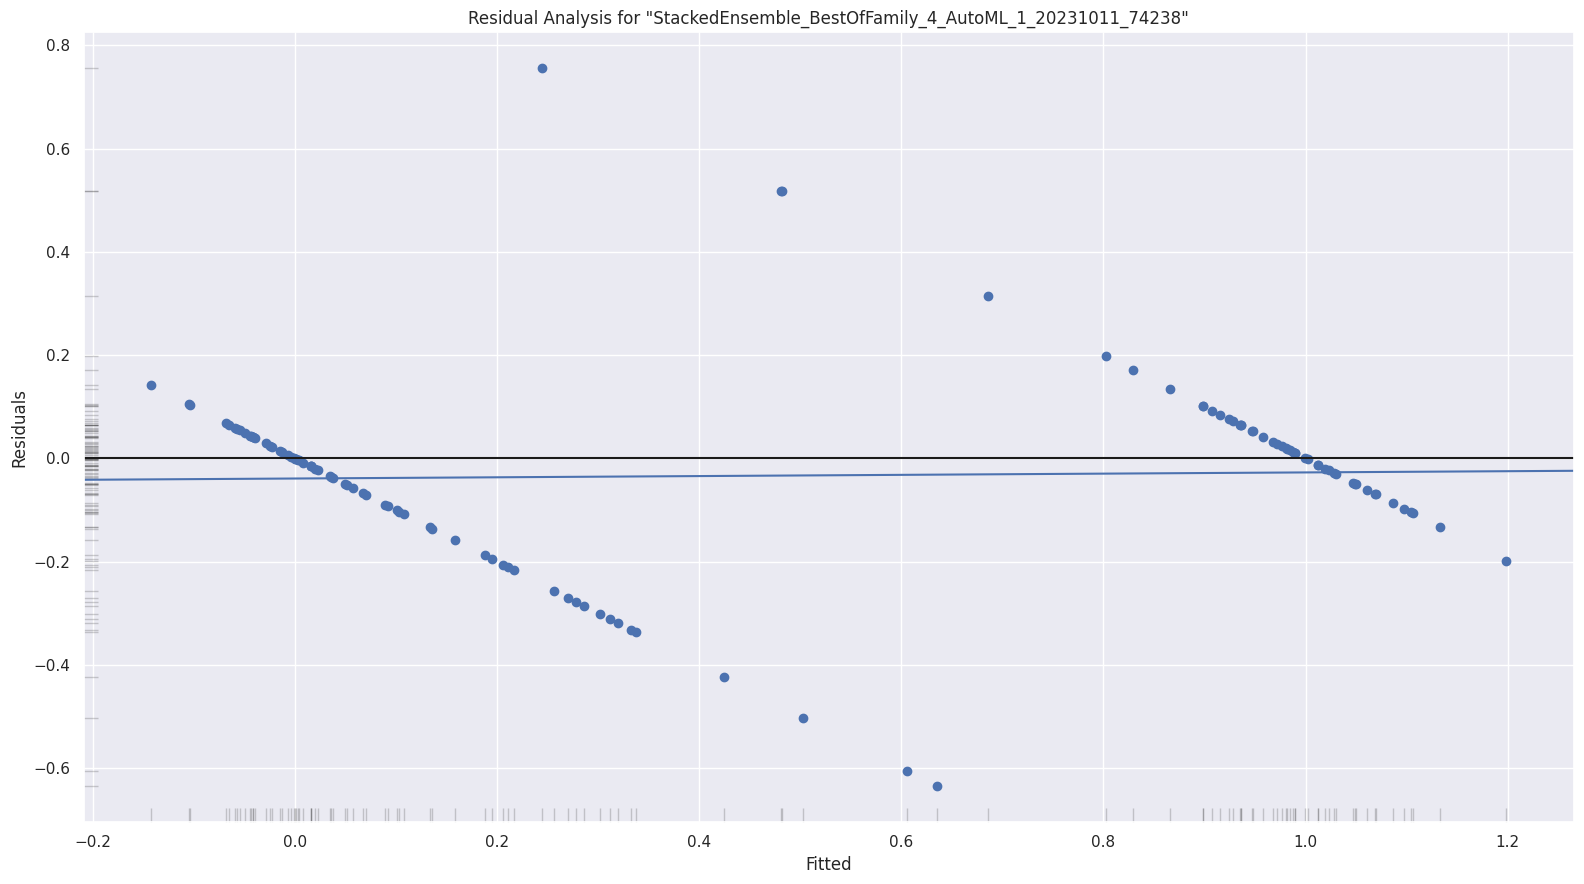

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

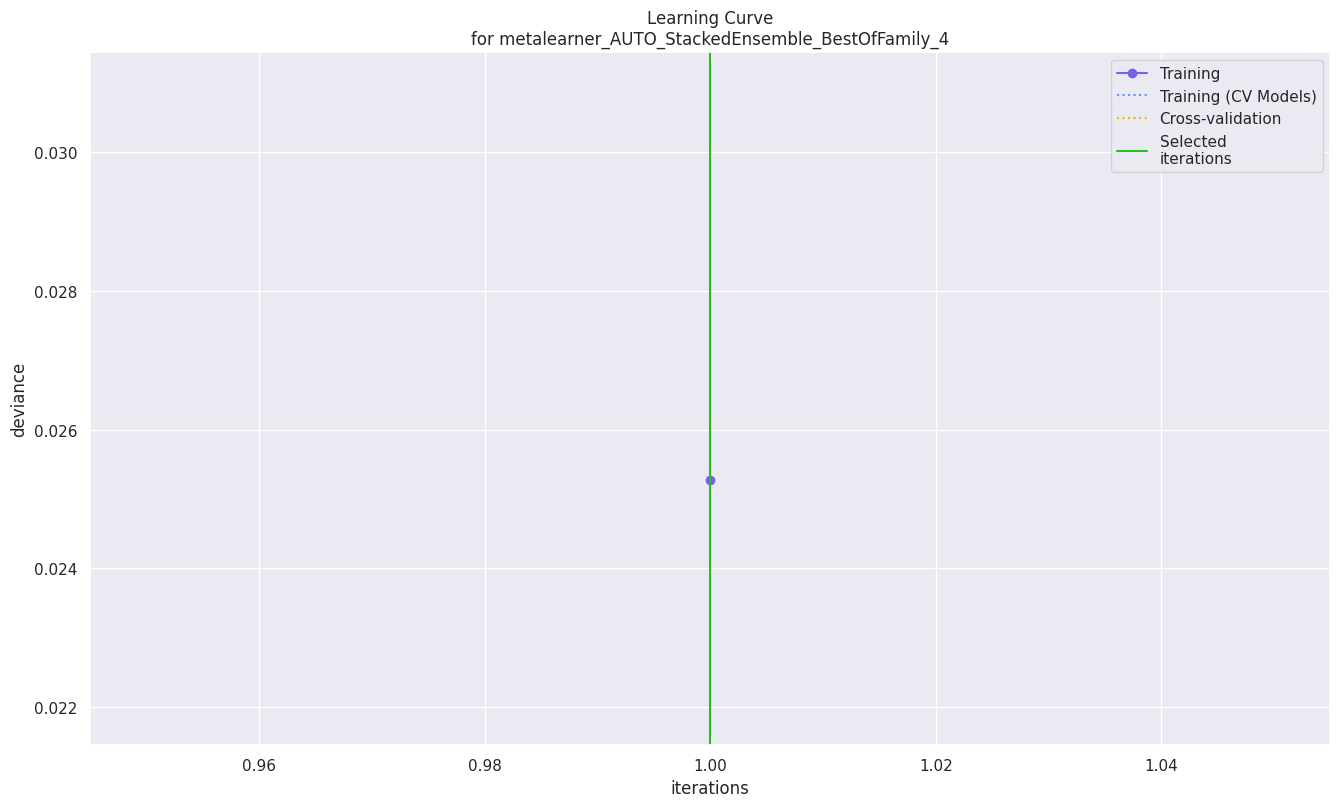

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

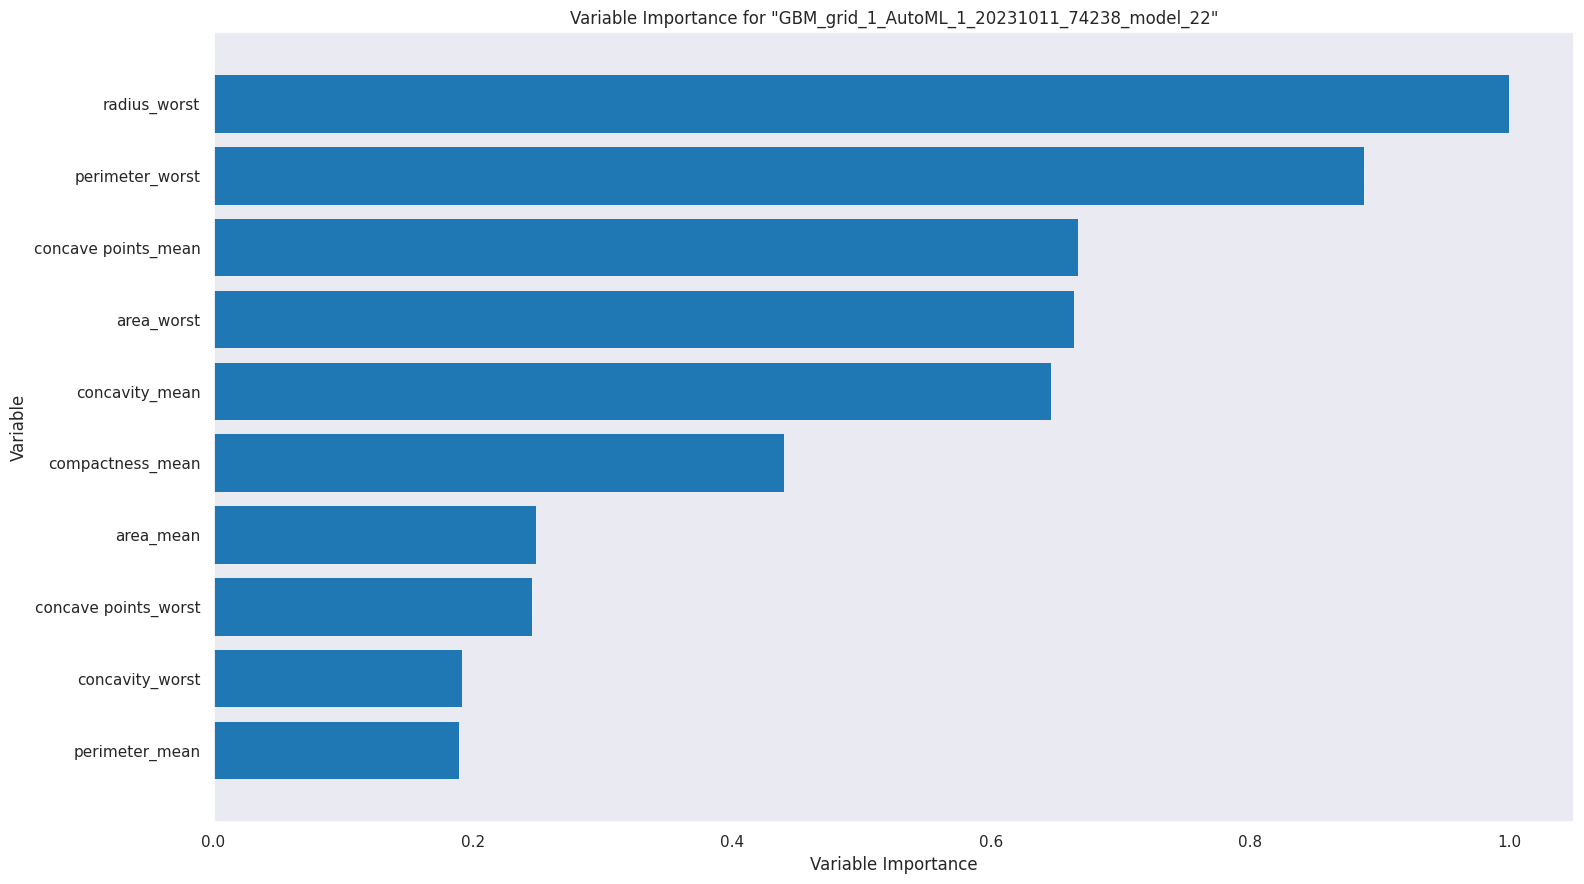

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

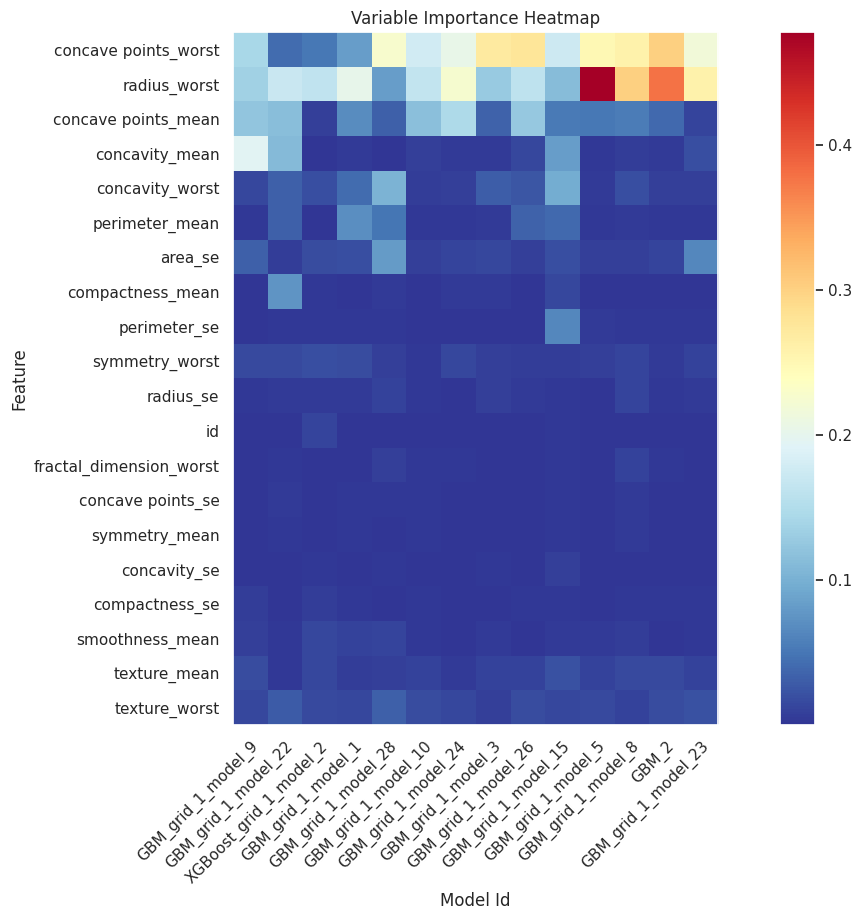

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

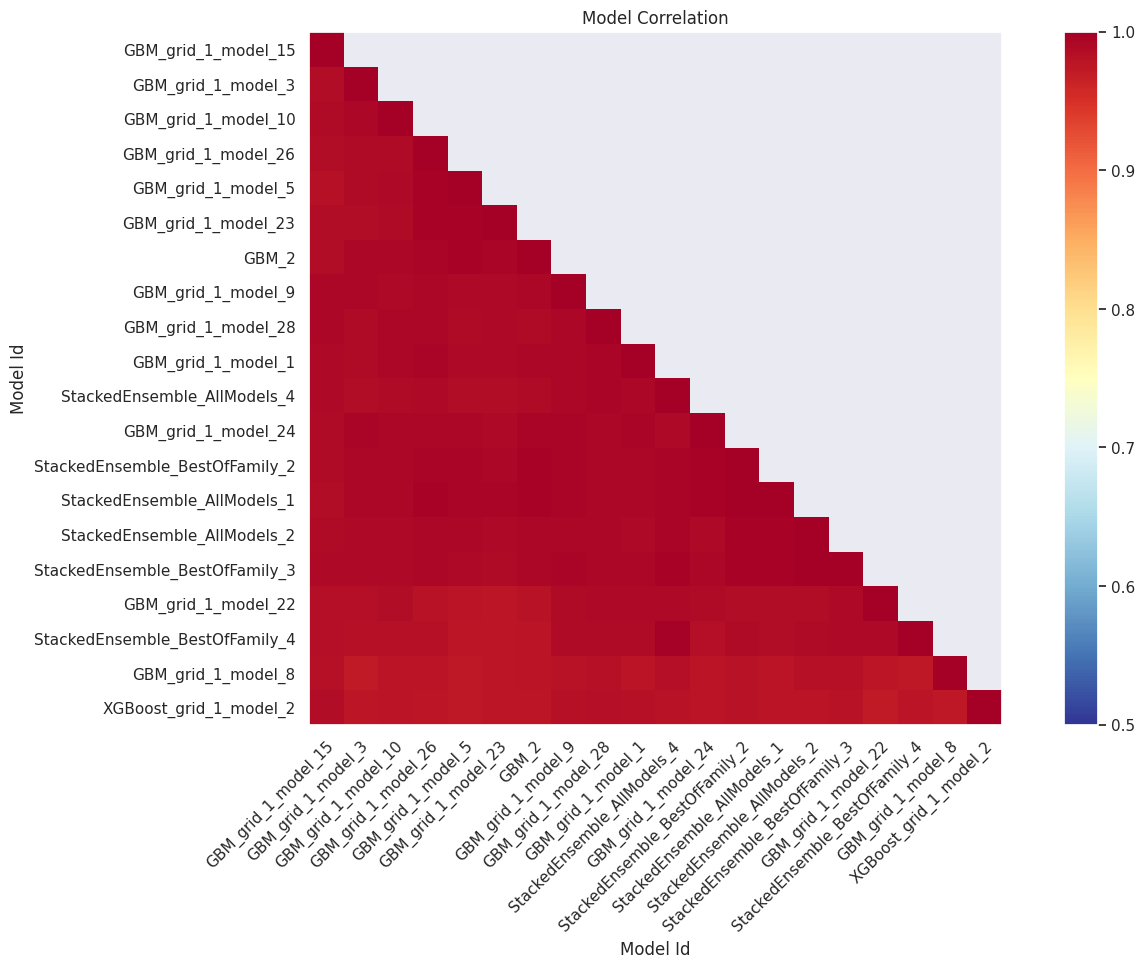

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

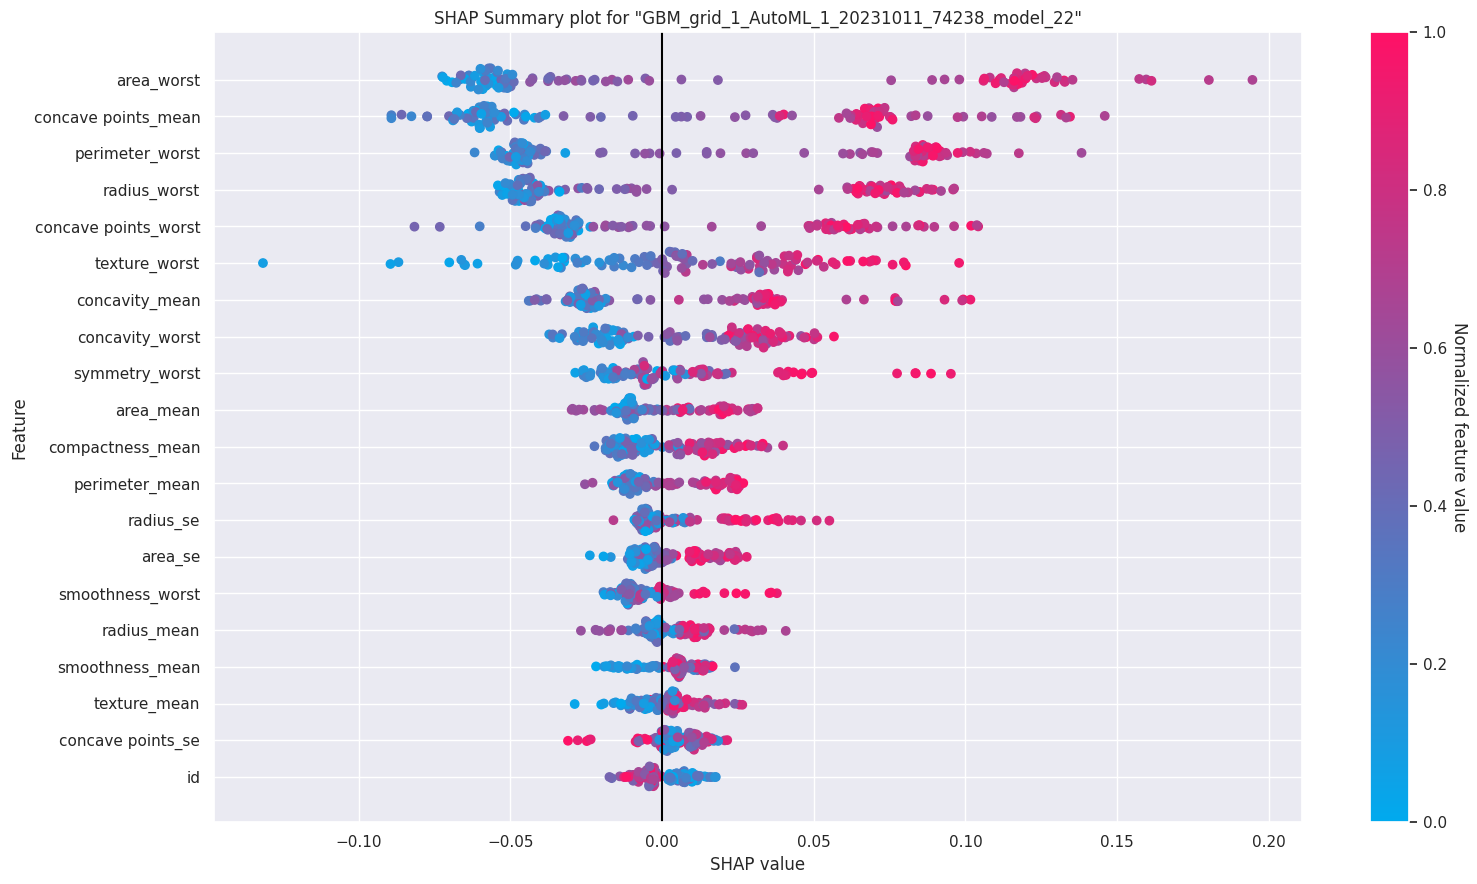

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

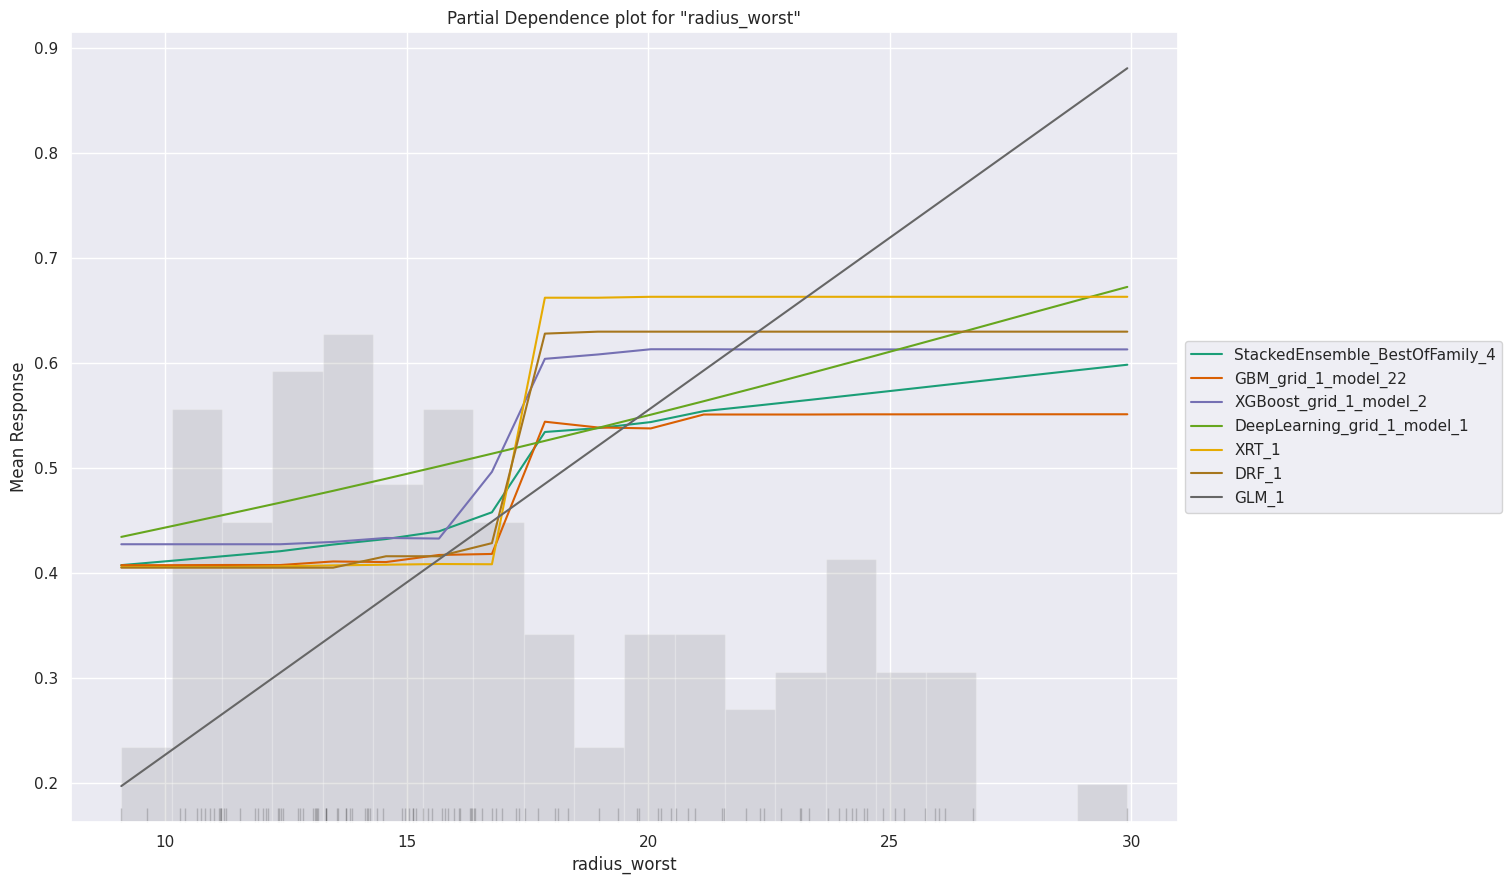

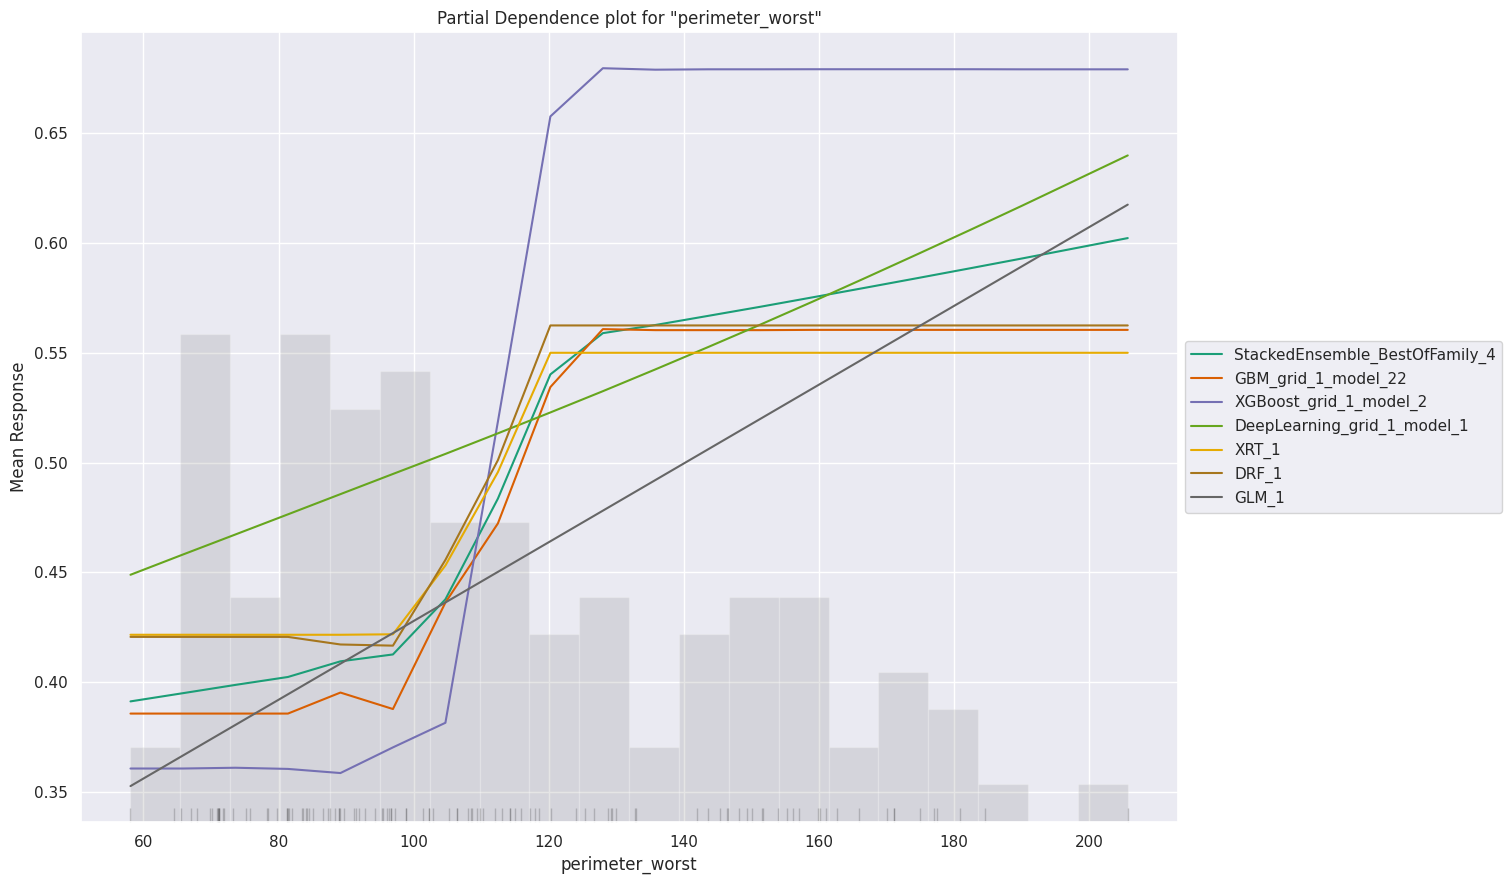

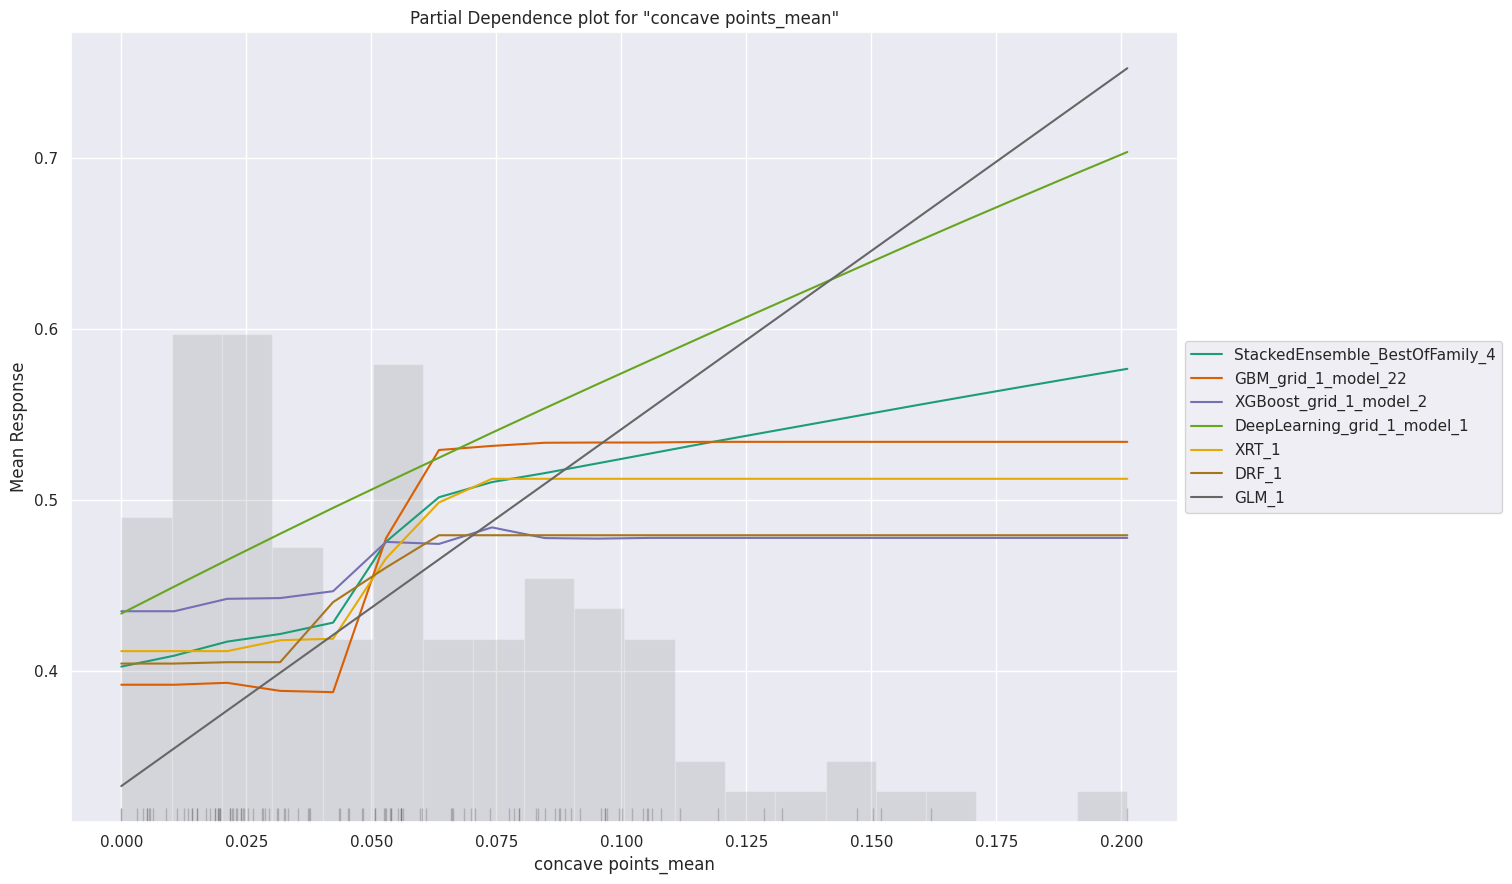

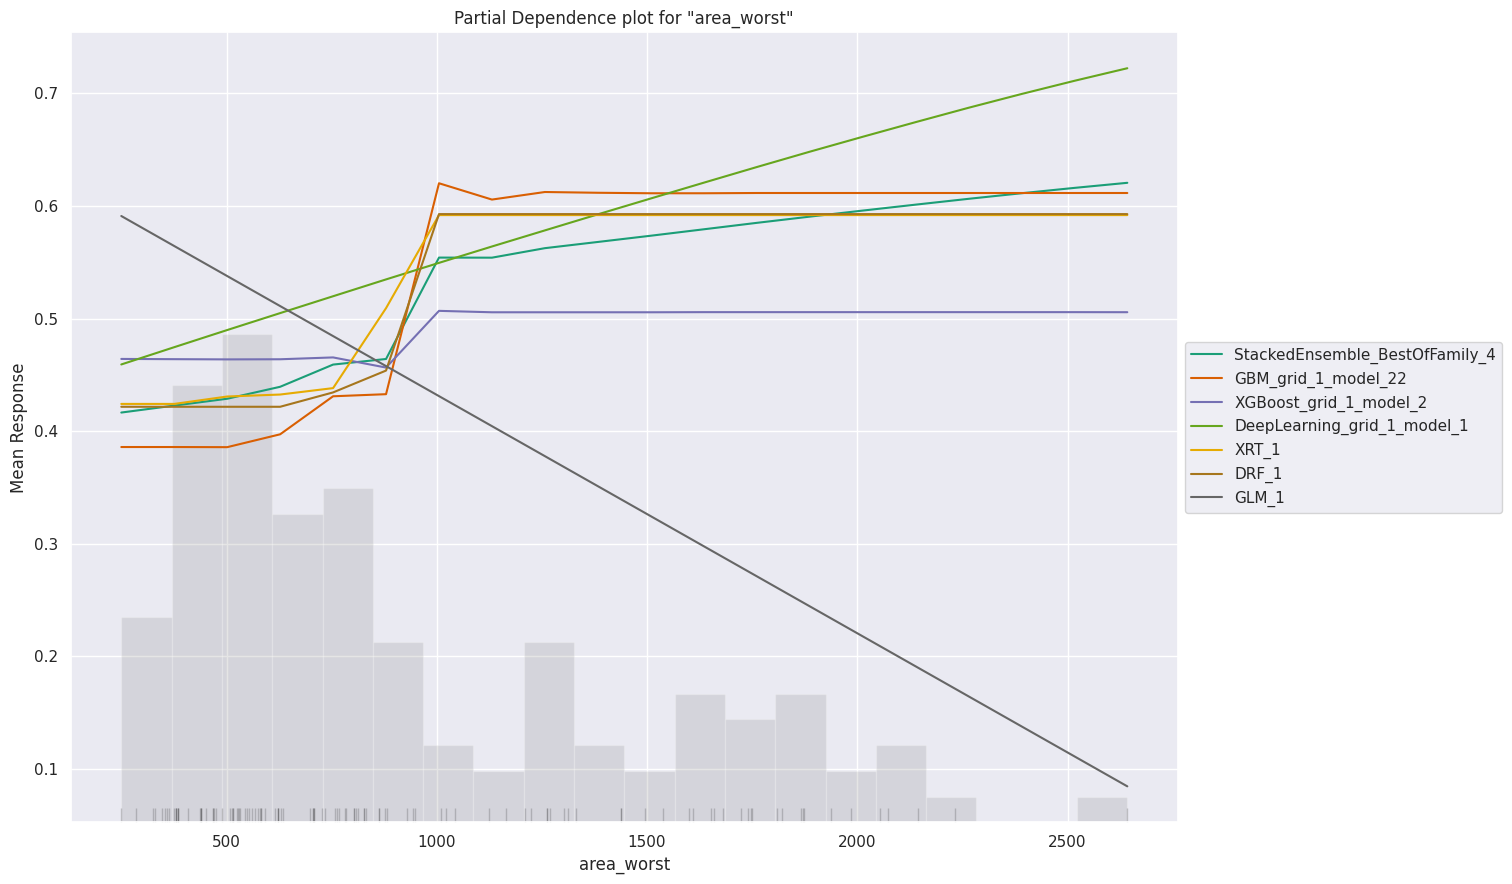

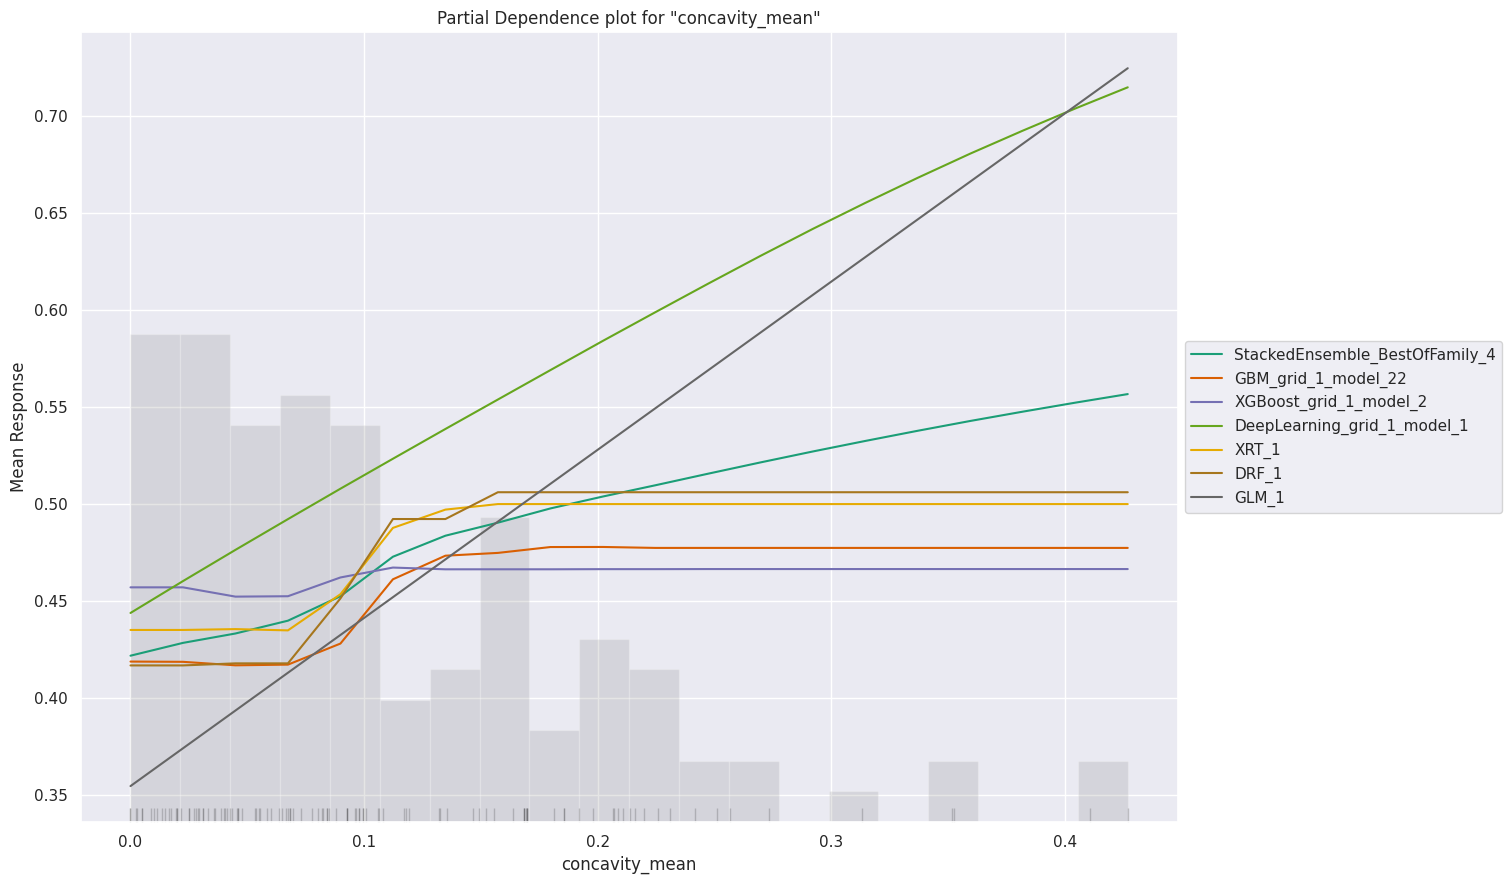

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

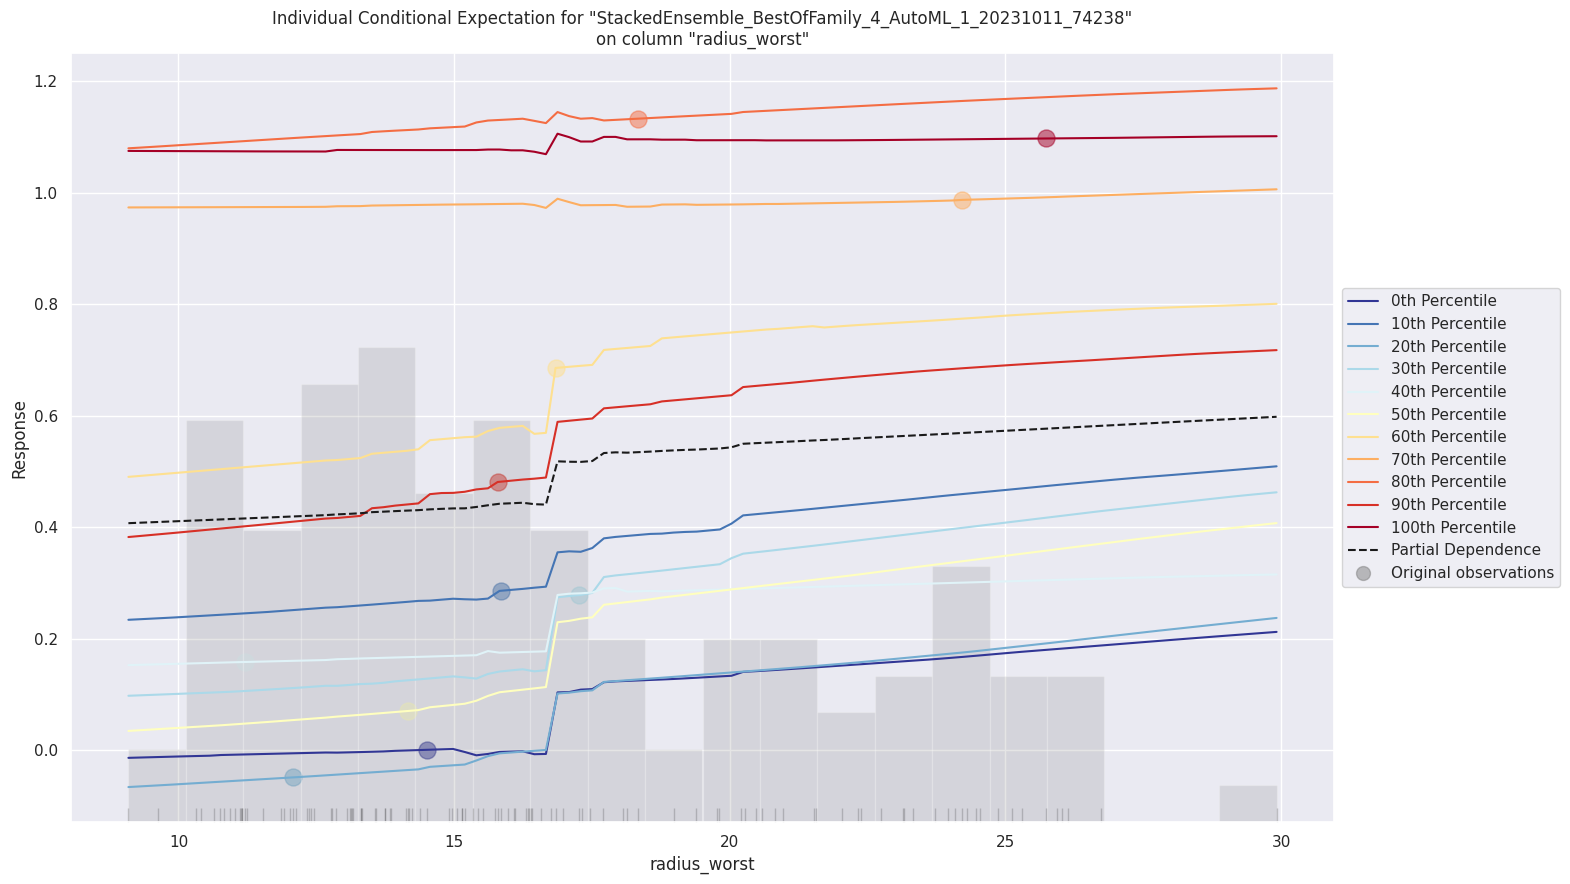

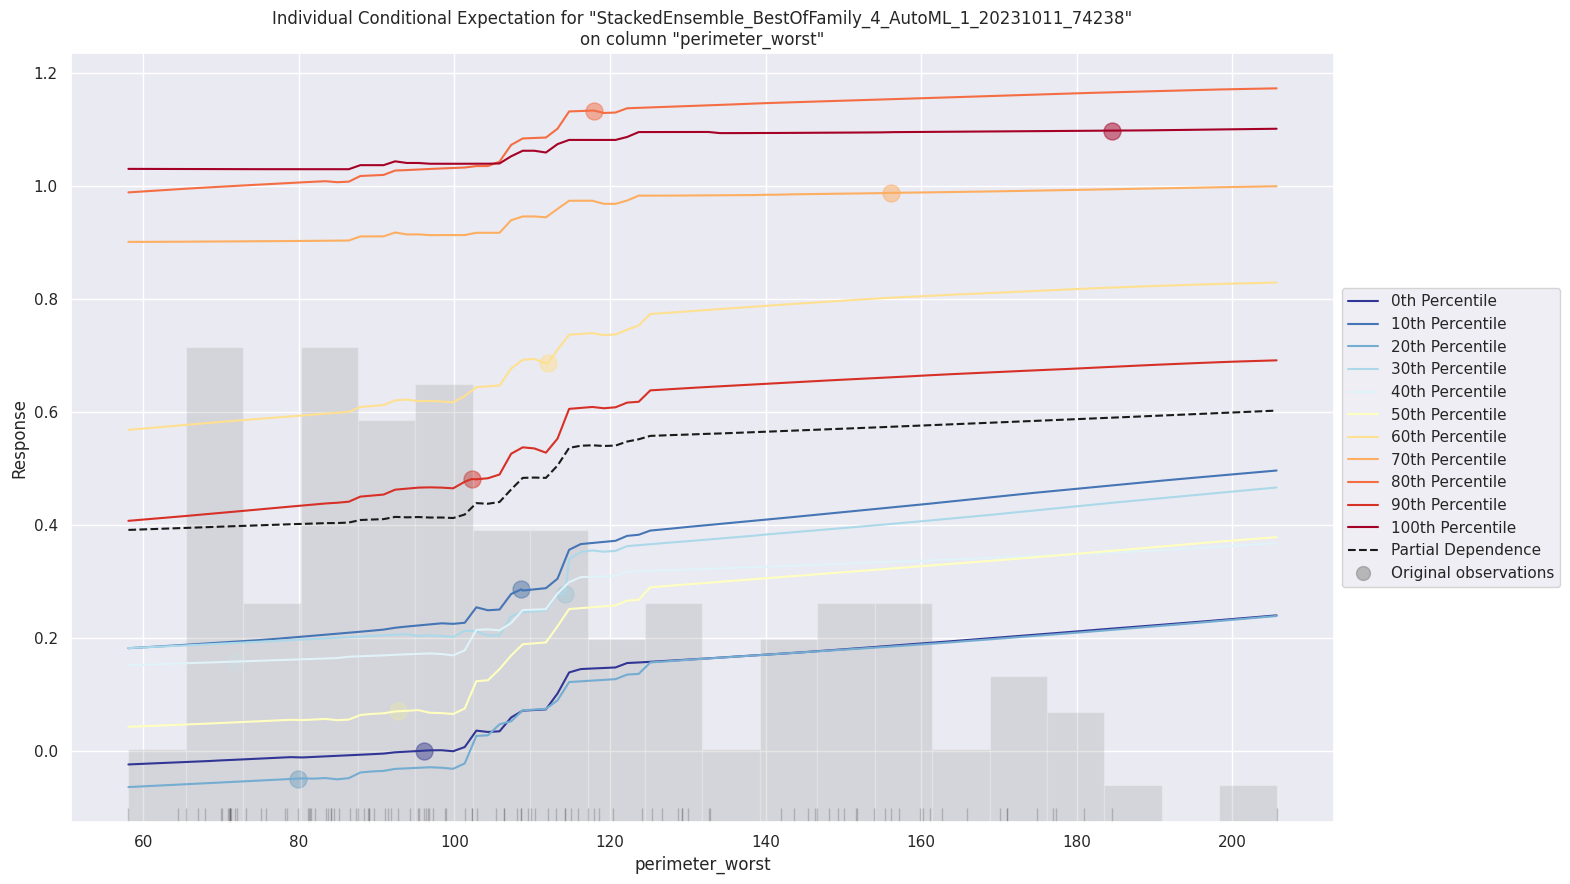

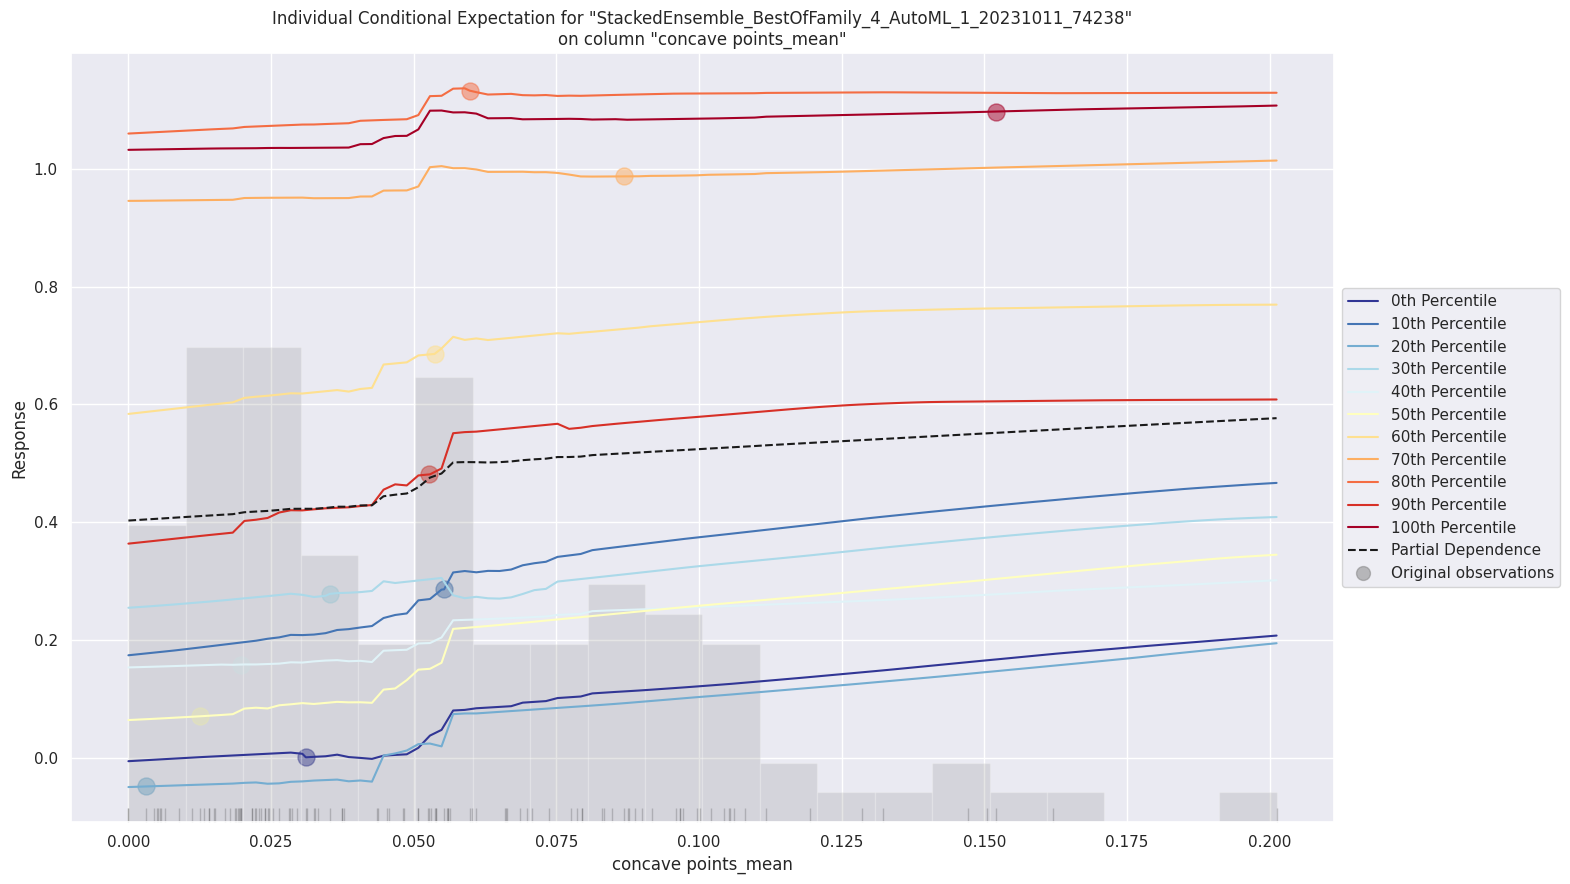

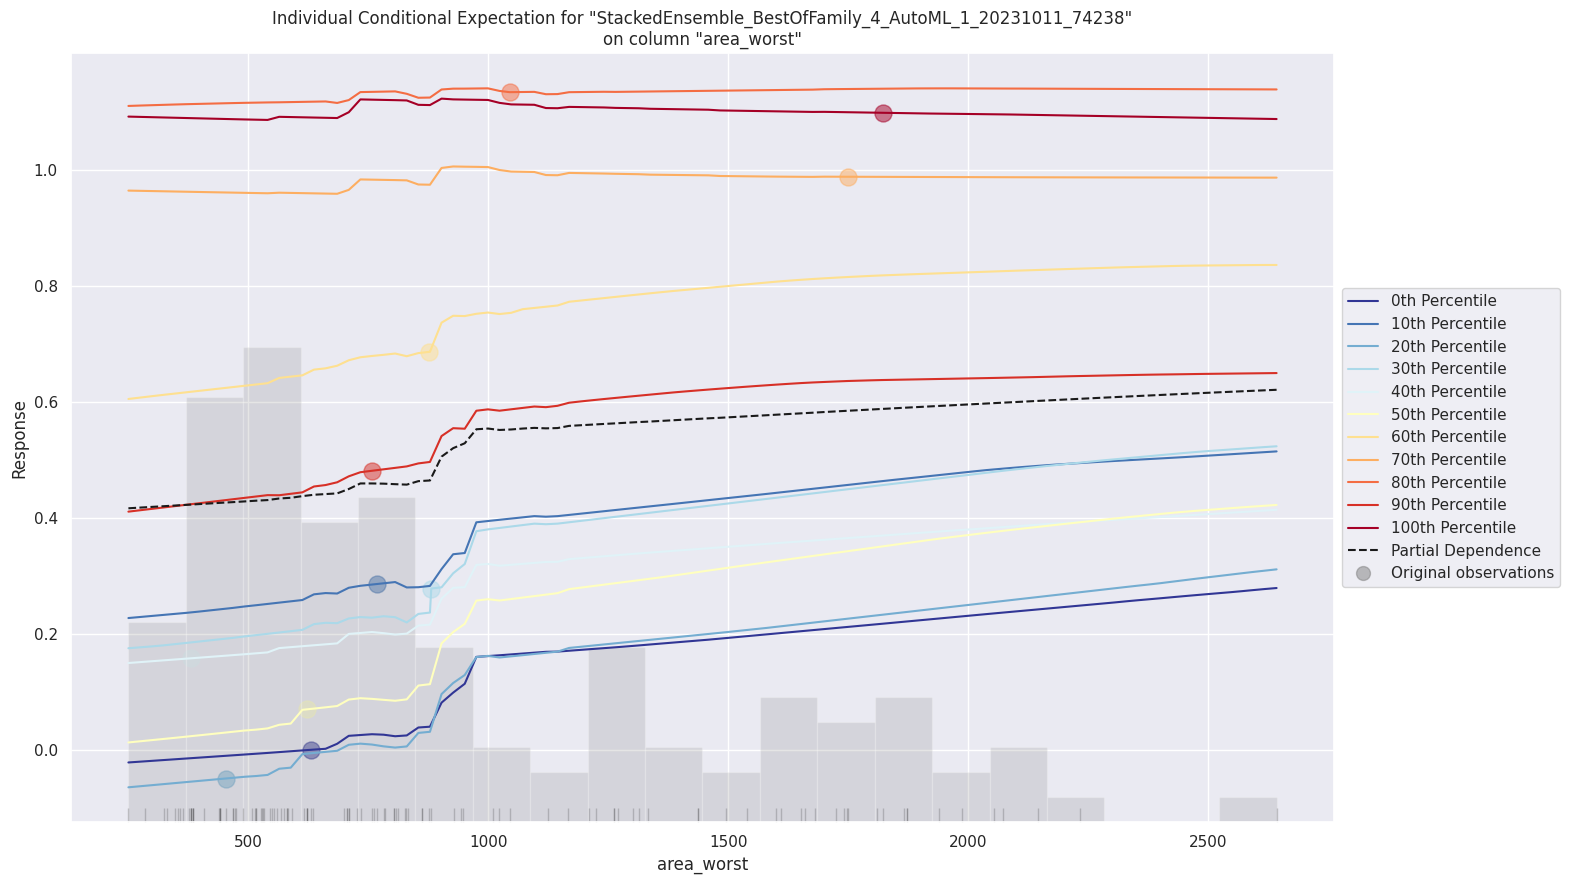

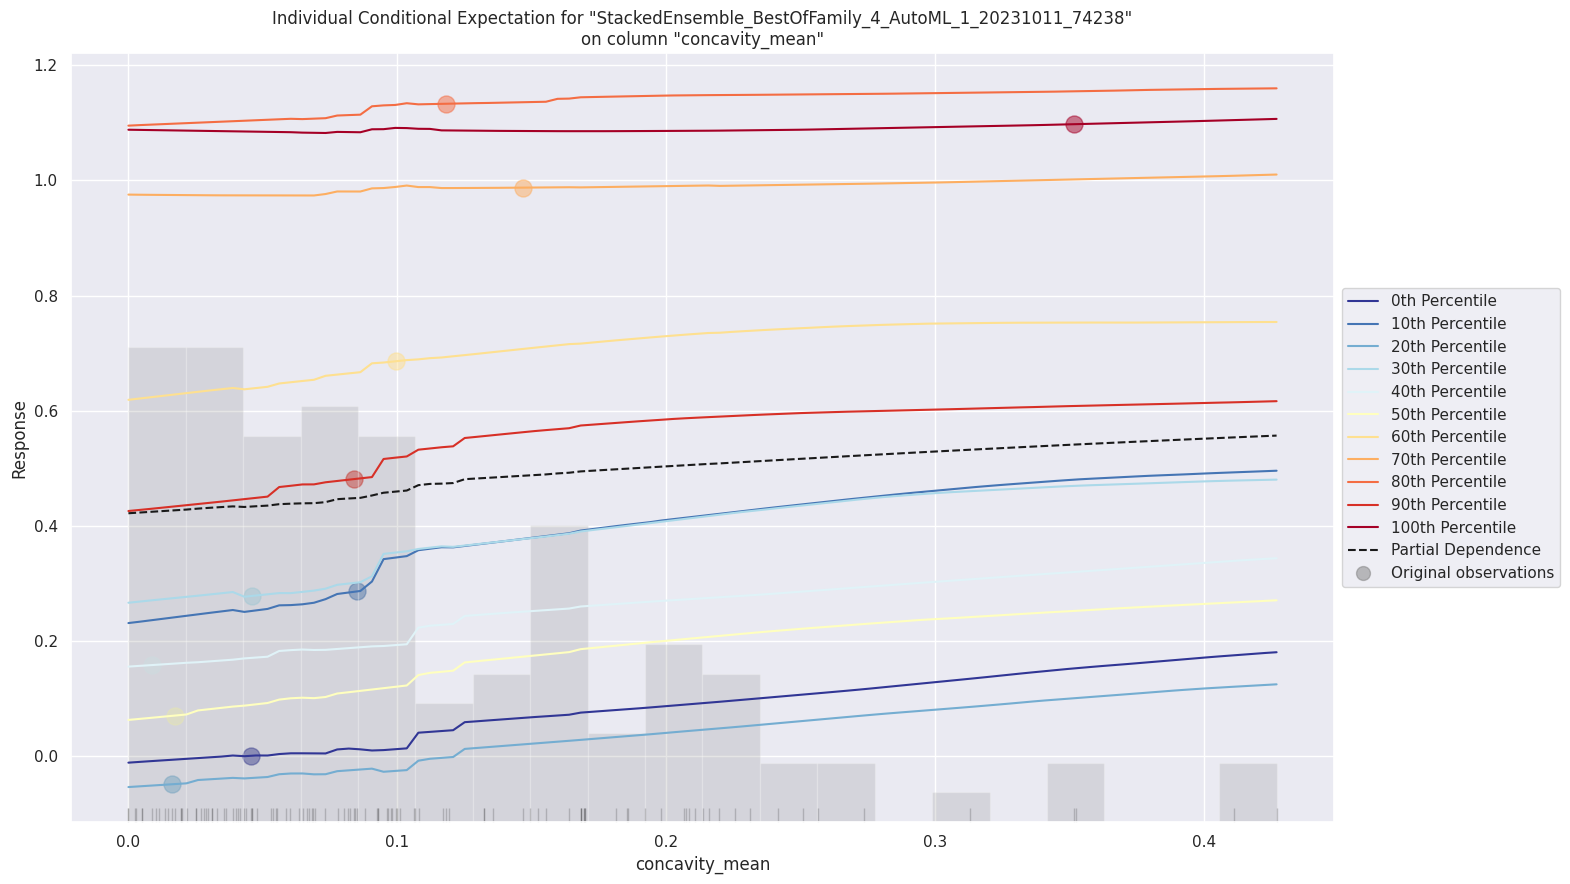

In [52]:
#calling explain method(The explain method generates explanations for the predictions made by the best model identified by the AutoML process.)
exa = aml.explain(df_test)

# **Interpreting Best Model from AutoML**

## **Residual Analysis**

Here, we can see the striped lines of residuals, which is an artifact of having an integer value as a response value, instead of a real value. It can also be observed from the above graph that residuals are normally distributed. Visuals signify that residuals don't have heteroscedasticity since the plot has striped lines and there is no cone shaped residual plot.



In [53]:
# OLS model Library
import statsmodels.formula.api as smf

In [54]:
# converts an H2O data frame object (df) into a pandas data frame object (pandas_df).
import h2o

pandas_df = h2o.as_list(df)

In [55]:
# Rename columns with spaces
pandas_df.columns = pandas_df.columns.str.replace(' ', '_')

# Then, generate the formula programmatically
dependent_var = 'diagnosis'
independent_vars = pandas_df.columns.drop(dependent_var)  # Drop the dependent variable
formula = dependent_var + ' ~ ' + ' + '.join(independent_vars)

# Run the regression
results = smf.ols(formula, data=pandas_df).fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              diagnosis   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     59.49
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          3.98e-152
Time:                        07:49:35   Log-Likelihood:                 29.849
No. Observations:                 569   AIC:                             4.303
Df Residuals:                     537   BIC:                             143.3
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.0179      0.428     -4.711      0.000      -2.859      -1.176
id                      -5.085e-11   8.31e-11     -0.612      0.541   -2.14e-10    1.12e-10
radius_mean                -0.2188      0.174     -1.260      0.208      -0.560       0.122
texture_mean                0.0047      0.008      0.595      0.552      -0.011       0.020
perimeter_mean              0.0237      0.025      0.945      0.345      -0.026       0.073
area_mean                   0.0003      0.001      0.614      0.539      -0.001       0.001
smoothness_mean             0.1063      2.019      0.053      0.958      -3.859       4.072
compactness_mean           -4.2390      1.335     -3.176      0.002      -6.861      -1.617
concavity_mean              1.4080      1.047      1.345      0.179      -0.648       3.464
concave_points_mean         2.1205      1.981      1.071      0.285      -1.770       6.011
symmetry_mean               0.1000      0.743      0.135      0.893      -1.360       1.560
fractal_dimension_mean     -0.0120      5.576     -0.002      0.998     -10.965      10.941
radius_se                   0.4254      0.311      1.368      0.172      -0.186       1.036
texture_se                 -0.0081      0.037     -0.218      0.827      -0.081       0.064
perimeter_se               -0.0227      0.041     -0.552      0.581      -0.104       0.058
area_se                    -0.0008      0.001     -0.587      0.557      -0.004       0.002
smoothness_se              16.1685      6.649      2.432      0.015       3.108      29.229
compactness_se              0.0281      2.172      0.013      0.990      -4.238       4.294
concavity_se               -3.5793      1.302     -2.750      0.006      -6.136      -1.022
concave_points_se          10.8305      5.472      1.979      0.048       0.081      21.580
symmetry_se                 1.6484      2.730      0.604      0.546      -3.715       7.012
fractal_dimension_se       -6.9457     11.688     -0.594      0.553     -29.905      16.014
radius_worst                0.1959      0.058      3.377      0.001       0.082       0.310
texture_worst               0.0072      0.007      1.031      0.303      -0.006       0.021
perimeter_worst            -0.0024      0.006     -0.411      0.682      -0.014       0.009
area_worst                 -0.0010      0.000     -3.171      0.002      -0.002      -0.000
smoothness_worst            0.5288      1.436      0.368      0.713      -2.291       3.349
compactness_worst           0.0736      0.383      0.192      0.848      -0.680       0.827
concavity_worst             0.3807      0.269      1.416      0.157      -0.147       0.909
concave_points_worst        0.4490      0.915      0.491      0.624      -1.349       2.247
symmetry_worst              0.5634      0.495  

results.summary(): This line prints a summary of the regression results to the console. The summary method is called on the results object, which generates a report that includes information such as the coefficients and standard errors of the regression equation, goodness-of-fit measures, and diagnostic statistics. This summary report can be useful for understanding the relationships between the dependent and independent variables, and for assessing the quality of the regression model.

Are any model assumptions violated?
Model Assumptions
We can see the striped lines of residuals, which is an artifact of having an integer value as a response value, instead of a real value. Here no heteroscadasticity is observed in the residual plot, hence this assumption is not violated.
If we look closely at the Heat map- We can see that from the plots, we do not have much high correlation between features.
If we look closely at the Pair-Plot - we can notice that every predictor variable has linear relationship with the target variable.
Durbin- Watson value is 1.366, which signifies that there is positive autocorrelation in our data, hence this assumption is not violated.
Based on the distributions I described earlier, it is possible that some of the variables violate the assumption of normality. For example, potassium, blood urea have positively skewed distributions, which could lead to non-normality of the residuals in a linear regression model.

Hyperparameter Tuning - Random Grid Search on GBM Model
The goal of hyperparameter tuning is to find the hyperparameters that produce the best performance on the test set, while avoiding overfitting on the training set. It is an important step in the machine learning pipeline, as the choice of hyperparameters can have a significant impact on the accuracy and generalization of a machine learning model.

In [56]:
#train test and split
train, validate, test = np.split(
    pandas_df.sample(frac=1, random_state=42), [int(0.6 * len(df)), int(0.8 * len(df))]
)

train = h2o.H2OFrame(train)
validate = h2o.H2OFrame(validate)
test = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [57]:
# The values of these keys are lists that contain different values for each hyperparameter that can be used to train a gradient boosting machine (GBM) model.
gbm_parameters = {
    "learn_rate": [i * 0.01 for i in range(1, 11)],
    "max_depth": list(range(2, 11)),
    "sample_rate": [i * 0.1 for i in range(5, 11)],
    "col_sample_rate": [i * 0.1 for i in range(1, 11)],
}

The purpose of creating this dictionary is to specify a grid of hyperparameters that can be used to train a GBM model. The ranges are taken randomly for each parameter(by printing each parameter you can understand the ranges). By combining different values for each hyperparameter, we can search for the combination that yields the best performance on a validation set. This process is known as hyperparameter tuning, and it's a common technique used to improve the performance of machine learning models.



In [58]:
search_criteria = {"strategy": "RandomDiscrete", "max_models": 36, "seed": 1}

Together, these search criteria specify a random search process that will train a maximum of 36 GBM models, randomly sampling hyperparameters from the grid defined in gbm_parameters. The goal of this process is to find the combination of hyperparameters that yields the best performance on a validation set, in order to create a well-performing GBM model.

In [59]:
#  creating the H2OGridSearch object
gbm_grid2 = H2OGridSearch(
    model=H2OGradientBoostingEstimator,
    grid_id="gbm_grid2",
    hyper_params=gbm_parameters,
    search_criteria=search_criteria,
)

In [62]:
feature_columns = train.columns
feature_columns.remove(y)  # Assuming 'y' has the correct target column name



In [63]:
gbm_grid2.train(
    x=feature_columns,
    y=y,
    training_frame=train,
    validation_frame=validate,
    ntrees=100,
    seed=1
)


gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


Hyper-Parameter Search Summary: ordered by increasing residual_deviance
     col_sample_rate      learn_rate    max_depth    sample_rate         model_ids           residual_deviance
---  -------------------  ------------  -----------  ------------------  ------------------  --------------------
     0.5                  0.1           9.0          1.0                 gbm_grid2_model_7   0.02404225865422452
     0.1                  0.07          7.0          0.8                 gbm_grid2_model_9   0.02474241098510057
     0.1                  0.06          8.0          0.9                 gbm_grid2_model_34  0.02510879837364267
     0.4                  0.08          6.0          0.9                 gbm_grid2_model_28  0.025315082830309654
     0.9                  0.09          8.0          0.9                 gbm_grid2_model_36  0.02582439617979488
     0.2                  0.04          5.0          0.9                 gbm_grid2_model_29  0.025997145419735468
     0.1                  0.08          3.0          0.8                 gbm_grid2_model_13  0.026166196714702637
     0.9                  0.1           4.0          0.7000000000000001  gbm_grid2_model_15  0.026656514119000954
     0.6000000000000001   0.1           4.0          1.0                 gbm_grid2_model_22  0.027222108368913134
     0.9                  0.04          4.0          0.9                 gbm_grid2_model_31  0.02755866522005243
---  ---                  ---           ---          ---                 ---                 ---
     0.1                  0.02          9.0          0.8                 gbm_grid2_model_16  0.03632673771580498
     0.8                  0.04          2.0          0.9                 gbm_grid2_model_4   0.03632951036533824
     0.5                  0.03          2.0          0.6000000000000001  gbm_grid2_model_26  0.03750642648876974
     0.2                  0.02          10.0         0.5                 gbm_grid2_model_25  0.0416052616644625
     0.30000000000000004  0.02          2.0          1.0                 gbm_grid2_model_20  0.0421250694640062
     0.5                  0.02          2.0          0.9                 gbm_grid2_model_35  0.04386962000540805
     0.5                  0.01          10.0         1.0                 gbm_grid2_model_24  0.06513346064121721
     0.6000000000000001   0.01          9.0          0.8                 gbm_grid2_model_11  0.0658678909836165
     1.0                  0.01          2.0          0.5                 gbm_grid2_model_23  0.07028244056364359
     1.0                  0.01          2.0          0.7000000000000001  gbm_grid2_model_10  0.07172643349763258
[36 rows x 7 columns]

In [64]:
#access information about best model
gbm_gridperf2 = gbm_grid2.get_grid()

In [65]:
print(gbm_gridperf2)

Hyper-Parameter Search Summary: ordered by increasing residual_deviance
     col_sample_rate      learn_rate    max_depth    sample_rate         model_ids           residual_deviance
---  -------------------  ------------  -----------  ------------------  ------------------  --------------------
     0.5                  0.1           9.0          1.0                 gbm_grid2_model_7   0.02404225865422452
     0.1                  0.07          7.0          0.8                 gbm_grid2_model_9   0.02474241098510057
     0.1                  0.06          8.0          0.9                 gbm_grid2_model_34  0.02510879837364267
     0.4                  0.08          6.0          0.9                 gbm_grid2_model_28  0.025315082830309654
     0.9                  0.09          8.0          0.9                 gbm_grid2_model_36  0.02582439617979488
     0.2                  0.04          5.0          0.9                 gbm_grid2_model_29  0.025997145419735468
     0.1               

In [66]:
#iterating the 36 parameters
list_hyperparameters = []
for i in range(36):
    hyperparameters = gbm_gridperf2.get_hyperparams_dict(i)
    list_hyperparameters.append(hyperparameters)

Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperparameters: [learn_rate, max_depth, sample_rate, col_sample_rate]
Hyperp

In [67]:
models = gbm_gridperf2.models

In [68]:
#printing the list of models residual_deviance
list_residual_deviance = []
for i in range(36):
    model = models[i]
    performance_metrics = model.model_performance(validate)
    residual_deviance = performance_metrics.mean_residual_deviance()
    list_residual_deviance.append(residual_deviance)

In [69]:
for i in range(36):
    list_hyperparameters[i]["Residual_Deviance"] = list_residual_deviance[i]

In [70]:
hyperparameters_dataframe = pd.DataFrame(list_hyperparameters)

In [71]:
print(hyperparameters_dataframe)

    col_sample_rate  learn_rate  max_depth  sample_rate  Residual_Deviance
0               0.5        0.10          9          1.0           0.024042
1               0.1        0.07          7          0.8           0.024742
2               0.1        0.06          8          0.9           0.025109
3               0.4        0.08          6          0.9           0.025315
4               0.9        0.09          8          0.9           0.025824
5               0.2        0.04          5          0.9           0.025997
6               0.1        0.08          3          0.8           0.026166
7               0.9        0.10          4          0.7           0.026657
8               0.6        0.10          4          1.0           0.027222
9               0.9        0.04          4          0.9           0.027559
10              0.6        0.09          3          0.9           0.028822
11              0.6        0.09          3          0.8           0.029076
12              0.9      

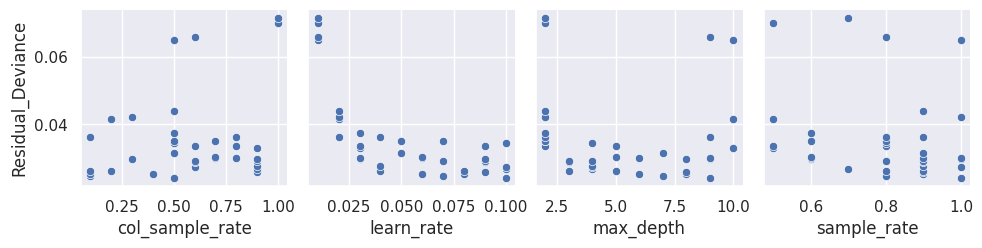

In [72]:
#plotting a grid of sctter plot
sns.pairplot(
    hyperparameters_dataframe,
    y_vars=["Residual_Deviance"],
    x_vars=["col_sample_rate", "learn_rate", "max_depth", "sample_rate"],
)